In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import subprocess
import os
from scipy.stats import mannwhitneyu
import statsmodels
from statsmodels.stats.multitest import fdrcorrection

## 1. LiftOver

We have our peaks for hg38 genome assembly version and RRBS methylation data for hg19 version, so we have to convert our peaks using LiftOver.

#### 1.1 Downloading overchain files for liftover converting (hg38tohg19):

In [2]:
!mkdir ./new

In [3]:
!mkdir ./new/overchain_files

In [224]:
!cd ./new/overchain_files && wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz

--2021-05-14 10:52:26--  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246411 (1,2M) [application/x-gzip]
Saving to: ‘hg38ToHg19.over.chain.gz’

hg38ToHg19.over.cha 100%[===================>]   1,19M   556KB/s    in 2,2s    

2021-05-14 10:52:30 (556 KB/s) - ‘hg38ToHg19.over.chain.gz’ saved [1246411/1246411]



#### 1.2 To avoid problems with converting we transform files with peaks to standard 3-columns bed format:

In [2]:
# directory with peaks files

bed_files = glob.glob("./our_new_peaks/*.narrowPeak")

In [11]:
!mkdir ./new/bed_files_3_col

In [3]:
for file in bed_files:
    file_name = file.split("/")[-1]
    !awk '{{print $$1, $$2, $$3}}' $file > "./new/bed_files_3_col/{file_name}"

#### 1.3 Now converting with LiftOver:

In [5]:
# directory for converted files

!mkdir ./new/converted_peaks

In [6]:
bed_files_3_col = glob.glob("./new/bed_files_3_col/*.narrowPeak")

In [8]:
%%capture
for file in bed_files_3_col:
    file_name = file.split("/")[-1]
    output = "./new/converted_peaks/" + file_name
    
    over_chain_file = './new/overchain_files/hg38ToHg19.over.chain.gz'
    unlifted_file = './new/converted_peaks/unlifted.bed'
        
    !liftOver $file $over_chain_file $output $unlifted_file

!rm ./new/converted_peaks/unlifted.bed

## 2. Sorting files

In [6]:
converted_files = glob.glob("./new/converted_peaks/*.narrowPeak")

In [17]:
!mkdir ./new/sorted_bed

In [7]:
for file in converted_files:
    file_name = file.split("/")[-1]
    !sort -k1,1 -k2n $file > "./new/sorted_bed/{file_name}"

## 3. Concensus peaks

In [838]:
bed_files = glob.glob("./new/sorted_bed/*.narrowPeak")

In [9]:
!mkdir "./new/sorted_bed/original_peaks"

We assume that the consensus peak regions are those that occur in at least half of the peak files under study.

In [839]:
# half of the files

len(bed_files) // 2

30

#### 3.1 Number of standard (not sloped) peaks, that occur in almost half of the files:

In [840]:
all_bed_files_str = ' '.join(bed_files)
!multiIntersectBed -i $all_bed_files_str > "./new/sorted_bed/original_peaks/multiintersected.bed"

!awk '{ if ($4 > 30) {print} }' ./new/sorted_bed/original_peaks/multiintersected.bed > ./new/sorted_bed/original_peaks/filtered.bed
!bedtools merge -i ./new/sorted_bed/original_peaks/filtered.bed > ./new/sorted_bed/original_peaks/merged.bed
number_of_peaks = !wc -l ./new/sorted_bed/original_peaks/merged.bed
number_of_peaks = int(number_of_peaks[0].split()[0])
print("Peaks number: ", number_of_peaks)

Peaks number:  31144


#### 3.2 Concensus peaks extracting:

In [13]:
# downloading hg19 ChromSizes file from UCSC database

!cd ./new/sorted_bed/ && fetchChromSizes hg19 > hg19.chrom.sizes

INFO: trying CURL  for database hg19
url: http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes


Figuring out how much to slop the peaks:

In [842]:
bed_files = glob.glob("./new/sorted_bed/*.narrowPeak")
chrom_sizes_file = "./new/sorted_bed/hg19.chrom.sizes"

number_of_peaks = [number_of_peaks]  # 31144 - number of standart peaks, not sloped

os.mkdir('./new/sorted_bed/intersected/')
os.mkdir('./new/sorted_bed/intersected/filtered')
os.mkdir('./new/sorted_bed/intersected/filtered/merged')

# slop peaks

for slop in range(1000, 6000, 1000): 
    sloped_files = []
    
    output_file_directory = "./new/sorted_bed/sloped_" + str(slop) + "/"
    os.mkdir(output_file_directory)
    
    for bed_file in bed_files:
        
        output_file_name = bed_file.split('/')[-1]
        output_file_path = output_file_directory + output_file_name
        
        with open(output_file_path, "w") as outfile:
            my_cmd = ['bedtools', 'slop', '-i', bed_file, '-g', chrom_sizes_file, '-b', str(slop)]
            subprocess.run(my_cmd, stdout=outfile)
            
        sloped_files.append(output_file_path)
        
    # intersect sloped peaks    
            
    sloped_intersect_output_path = "./new/sorted_bed/intersected/sloped_" + str(slop) + ".bed"
    with open(sloped_intersect_output_path, 'w') as outfile:
        subprocess.run(['multiIntersectBed', '-i'] + sloped_files, stdout=outfile)
    
# filter peaks regions where there are almost half of files in intersection area
    
intersected_files = glob.glob("./new/sorted_bed/intersected/*.bed")

for file in intersected_files:
    
    filtered_file_name = file.split('/')[-1]
    filtered_file_path = "./new/sorted_bed/intersected/filtered/" + filtered_file_name
    
    with open(filtered_file_path, "w") as outfile:
        subprocess.run(['awk', '{ if ($4 > 30) {print} }', file], stdout=outfile)

# merge filtered peaks
        
filtered_files = glob.glob("./new/sorted_bed/intersected/filtered/*.bed")


for file in sorted(filtered_files):
    
    merged_file_name = file.split('/')[-1]
    merged_file_path = "./new/sorted_bed/intersected/filtered/merged/" + merged_file_name
    
    with open(merged_file_path, "w") as outfile:
        subprocess.run(['bedtools', 'merge', '-i', file], stdout=outfile)
    
    # count number of merged peaks
    
    wc = subprocess.Popen(['wc', '-l', merged_file_path], stdout=subprocess.PIPE)
    output = subprocess.check_output(('awk', '{ print $1 }'), stdin=wc.stdout)
    wc.wait()
    number_of_peaks.append(int(output[:-1]))

In [843]:
number_of_peaks

[31144, 59849, 84919, 95054, 92473, 85480]

In [73]:
slop_range = list(range(1000, 6000, 1000))
slop_range.insert(0, 0)
slop_range

[0, 1000, 2000, 3000, 4000, 5000]

Text(0, 0.5, 'Number of peaks')

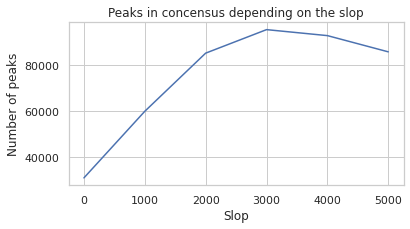

In [88]:
sns.set(rc={'figure.figsize':(6, 3)}, style='whitegrid')
plt.plot(slop_range, number_of_peaks) 
plt.title("Peaks in concensus depending on the slop")
plt.xlabel("Slop")
plt.ylabel("Number of peaks")

Thus, we found out that the cutoff is the slop value 3000.

In [ ]:
## Move sloped 3000 file to /concensus_peaks_sloped_our_results directory

!mv ./new/sorted_bed/intersected/filtered/merged/sloped_3000.bed ./concensus_peaks_sloped_our_results/

## 4. Converting RRBS data to bed format 

In [ ]:
def tsv_to_bed(input_file, output_file):
    with open(input_file, 'r') as data, open(output_file, 'w') as output:
        data.readline()  # skip header

        while True:
            line = data.readline()

            if not line:
                break

            line = line.replace(".", "\t", 1)
            splited_line = line.split("\t", 2)
            splited_line.insert(2, str(int(splited_line[1]) + 1))
            new_out = '{}\t{}\t{}\t{}'.format(splited_line[0], splited_line[1], splited_line[2], splited_line[3])
            output.write(new_out)

In [ ]:
tsv_to_bed('filtered_cytosines_freq.tsv', 'filtered_cytosines_freq.bed')

## 5. Mapping RRBS data to consensus peaks regions

In [10]:
%%capture
# average methylation in peaks regions in old donors

!bedtools map -a ./concensus_peaks_sloped_our_results/sloped_3000.bed -b ./concensus_peaks_sloped_our_results/filtered_cytosines_freq_sorted.bed -c 4,5,6,7,8,9,10,12,13,14,15,16,17,18,20,21,22,23 -o mean > ./concensus_peaks_sloped_our_results/old_mean_methyl_3000.bed

In [11]:
%%capture
# average methylation in peaks regions in young donors

!bedtools map -a ./concensus_peaks_sloped_our_results/sloped_3000.bed -b ./concensus_peaks_sloped_our_results/filtered_cytosines_freq_sorted.bed -c 24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42 -o mean > ./concensus_peaks_sloped_our_results/young_mean_methyl_3000.bed

## 6. Search for differentially methylated regions in young and old donors

#### 6.1 Data preparation 

In [9]:
# reading old
old = pd.read_table("./concensus_peaks_sloped_our_results/old_mean_methyl_3000.bed", sep="\t", header=None)

# reading young
young = pd.read_table("./concensus_peaks_sloped_our_results/young_mean_methyl_3000.bed", sep="\t", header=None)

In [10]:
# missing values to NaN

old.iloc[:,1:] = old.iloc[:,1:].apply(pd.to_numeric, errors='coerce') 
young.iloc[:,1:] = young.iloc[:,1:].apply(pd.to_numeric, errors='coerce') 

In [685]:
old.head()

0      1      2          3   4   5   6          7   8          9   \
0  chr1  10303  17812  94.616545 NaN NaN NaN  97.780727 NaN  95.276636   
1  chr1  18162  18176        NaN NaN NaN NaN        NaN NaN        NaN   
2  chr1  18191  24536        NaN NaN NaN NaN        NaN NaN        NaN   
3  chr1  33641  35927        NaN NaN NaN NaN        NaN NaN        NaN   
4  chr1  37346  40001        NaN NaN NaN NaN        NaN NaN        NaN   

          10  11         12  13         14         15         16  17  \
0  89.097818 NaN  86.370727 NaN  87.621727  95.586364  93.205273 NaN   
1        NaN NaN        NaN NaN        NaN        NaN        NaN NaN   
2        NaN NaN        NaN NaN        NaN        NaN        NaN NaN   
3        NaN NaN        NaN NaN        NaN        NaN        NaN NaN   
4        NaN NaN        NaN NaN        NaN        NaN        NaN NaN   

          18         19  20  
0  95.097727  95.939091 NaN  
1        NaN        NaN NaN  
2        NaN        NaN NaN  
3        NaN        NaN NaN  
4        NaN        NaN NaN

In [686]:
young.head()

0      1      2          3          4          5       6   7          8   \
0  chr1  10303  17812  70.338818  95.993545  95.658727  97.259 NaN  97.948182   
1  chr1  18162  18176        NaN        NaN        NaN     NaN NaN        NaN   
2  chr1  18191  24536        NaN        NaN        NaN     NaN NaN        NaN   
3  chr1  33641  35927        NaN        NaN        NaN     NaN NaN        NaN   
4  chr1  37346  40001        NaN        NaN        NaN     NaN NaN        NaN   

       9          10         11         12  13         14         15  16  \
0  92.145  97.636364  95.144455  24.926636 NaN  86.696364  94.375636 NaN   
1     NaN        NaN        NaN        NaN NaN        NaN        NaN NaN   
2     NaN        NaN        NaN        NaN NaN        NaN        NaN NaN   
3     NaN        NaN        NaN        NaN NaN        NaN        NaN NaN   
4     NaN        NaN        NaN        NaN NaN        NaN        NaN NaN   

          17         18  19         20         21  
0  97.873545  51.449545 NaN  93.399273  96.063727  
1        NaN        NaN NaN        NaN        NaN  
2        NaN        NaN NaN        NaN        NaN  
3        NaN        NaN NaN        NaN        NaN  
4        NaN        NaN NaN        NaN        NaN

In [11]:
# concatenating interval genome coordinates into one column

old.insert(0, 'interval', old[old.columns[:3]].apply(lambda x: ':'.join(x.astype(str)), axis=1))

In [12]:
# concatenating interval genome coordinates into one column

young.insert(0, 'interval', young[young.columns[:3]].apply(lambda x: ':'.join(x.astype(str)), axis=1))

#### We need to filter rows where number of missing values >= 3:

In [274]:
pd.set_option('display.max_columns', None)

In [13]:
old_sub = old[old.iloc[:, 4:].notnull().sum(axis=1) >= 3] 
young_sub = young[young.iloc[:, 4:].notnull().sum(axis=1) >= 3] 

In [17]:
# number of rows in filtered old data

old_sub.shape[0]

44629

In [18]:
# number of rows in filtered young data

young_sub.shape[0]

44666

In [14]:
# inner join по колонке interval
common = old_sub.merge(young_sub, on=["interval"])

# number of matching intervals
common.shape[0]  

44553

In [692]:
common.head()

interval   0_x     1_x     2_x        3_x        4_x        5_x  \
0    chr1:10303:17812  chr1   10303   17812  94.616545        NaN        NaN   
1  chr1:134459:140186  chr1  134459  140186  75.885545        NaN  78.575364   
2  chr1:543655:550843  chr1  543655  550843  22.982600  28.687400        NaN   
3  chr1:561504:573288  chr1  561504  573288  76.826000  66.667000  67.593500   
4  chr1:661542:665080  chr1  661542  665080  75.296583  77.638917  75.197750   

         6_x        7_x        8_x        9_x       10_x       11_x  \
0        NaN  97.780727        NaN  95.276636  89.097818        NaN   
1  75.564000  79.801636  77.277091  76.308636  73.210909  77.799909   
2  24.429400  26.521800  20.000000        NaN  25.775000  24.422600   
3  85.714000  81.905000  85.095000  72.954500  91.846000   0.000000   
4  80.217417  81.559833  75.874250  79.096500  76.281500  78.735500   

        12_x       13_x       14_x       15_x       16_x       17_x  \
0  86.370727        NaN  87.621727  95.586364  93.205273        NaN   
1  78.461727        NaN        NaN  72.551727  74.864727        NaN   
2        NaN  14.282200  40.000000  20.000000        NaN  30.434800   
3  58.006500  84.288000  85.664500  77.753000  75.537500  60.000000   
4  81.794250  79.619917  78.407917  79.408250  78.411667  78.631083   

        18_x       19_x       20_x   0_y     1_y     2_y        3_y  \
0  95.097727  95.939091        NaN  chr1   10303   17812  70.338818   
1  76.722364  77.692091  76.917273  chr1  134459  140186  78.312000   
2        NaN  33.784800   0.000000  chr1  543655  550843  20.683800   
3  64.741000   0.000000  46.311500  chr1  561504  573288  56.135500   
4  76.042250  77.090583  78.497500  chr1  661542  665080  78.208750   

         4_y        5_y        6_y        7_y        8_y        9_y  \
0  95.993545  95.658727  97.259000        NaN  97.948182  92.145000   
1  79.325273  75.830818  72.130091  77.839000  76.273091  75.529455   
2  33.517600  30.911800  40.000000  34.285600        NaN  20.000000   
3  86.516500  73.429500  89.425500  90.230000  81.927500  80.769000   
4  77.815583  77.900333  75.260417  79.420583  82.069083  76.637667   

        10_y       11_y       12_y       13_y       14_y       15_y  \
0  97.636364  95.144455  24.926636        NaN  86.696364  94.375636   
1        NaN  76.717364  77.844182  76.345909  76.862000  78.574727   
2        NaN  23.676800        NaN  22.642600  20.512800        NaN   
3  79.545000  88.651000  73.699500  91.496500  67.948500  74.157000   
4  74.891417  80.450917  78.102083        NaN  75.805917  77.524833   

        16_y       17_y       18_y       19_y       20_y         21  
0        NaN  97.873545  51.449545        NaN  93.399273  96.063727  
1  68.314364  78.030909  79.340273  77.480000  76.482091  79.599273  
2        NaN        NaN  29.572200  31.570800        NaN  23.555600  
3  83.772000  71.875000  76.709000   5.263000  71.640500  85.083500  
4  79.838917  78.332500  76.366000  79.295167  77.144583  76.586500

In [15]:
# from filtered young data we leave only rows that hit inner join 
young_res = young_sub[young_sub["interval"].isin(common["interval"])] 

# from filtered old data we leave only rows that hit inner join 
old_res = old_sub[old_sub["interval"].isin(common["interval"])]  # из старых оставляем только те, которые попали в inner join

#### 6.2 Mann-Whitney test 

In [16]:
meth_regions_mw = pd.DataFrame(columns=["interval", "stat", "p_val"])
meth_regions_mw

Empty DataFrame
Columns: [interval, stat, p_val]
Index: []

In [17]:
for i in range(len(old_res)):
    try:
        stat, p = mannwhitneyu(old_res.iloc[i,4:], young_res.iloc[i,4:])
    except ValueError:  # All numbers are identical in mannwhitneyu
        stat, p = (0, 1)
    meth_regions_mw = meth_regions_mw.append({'interval': old_res.iloc[i,0], 'stat': stat, 'p_val': p}, ignore_index=True)

In [23]:
meth_regions_mw.head()

interval   stat     p_val
0    chr1:10303:17812  139.0  0.169237
1  chr1:134459:140186  159.0  0.363376
2  chr1:543655:550843  109.0  0.030826
3  chr1:561504:573288  127.0  0.093100
4  chr1:661542:665080  143.0  0.201679

In [18]:
# multiple comparison adjustment

multicomparison = statsmodels.stats.multitest.multipletests(meth_regions_mw["p_val"], alpha=0.05, method='holm-sidak')
meth_regions_mw['pvalue-%s' % 'hs'] = multicomparison[1]
meth_regions_mw['reject-%s' % 'hs'] = multicomparison[0]

In [19]:
diff_methylated = meth_regions_mw[meth_regions_mw["reject-hs"] == True]

In [26]:
diff_methylated

interval  stat         p_val  pvalue-hs  reject-hs
173        chr1:3000150:3007572  13.0  8.509874e-07   0.037048       True
470        chr1:9317697:9324383   8.0  3.949142e-07   0.017410       True
617      chr1:12048280:12054670  15.0  1.149693e-06   0.049669       True
1357     chr1:29205521:29216481  10.0  5.383104e-07   0.023634       True
1537     chr1:33768785:33782835   9.0  4.612767e-07   0.020298       True
...                         ...   ...           ...        ...        ...
43353  chr9:136470320:136476950   2.0  1.526178e-07   0.006776       True
43639  chr9:140110516:140112029   2.0  1.526178e-07   0.006776       True
43733      chrX:9753563:9754258  12.0  7.311618e-07   0.031933       True
43942    chrX:48836937:48848107  11.0  6.276489e-07   0.027488       True
44428  chrX:150343155:150351551   3.0  1.792222e-07   0.007950       True

[262 rows x 5 columns]

In [20]:
# from methylation data in young and old donors we take only differentially methylated intervals

young_diff_meth_regions = young[young["interval"].isin(diff_methylated["interval"])]  
old_diff_meth_regions = old[old["interval"].isin(diff_methylated["interval"])] 

In [18]:
young_diff_meth_regions.shape

(262, 23)

In [19]:
old_diff_meth_regions.shape

(262, 22)

In [21]:
# calculating average methylation for all old donors in each interval to new df with age assignment

old_avg_meth = pd.DataFrame({'interval': old_diff_meth_regions["interval"], 'mean_meth': old_diff_meth_regions.iloc[:,4:].mean(axis=1)}).assign(Age='old')

In [22]:
# calculating average methylation for all young donors in each interval to new df with age assignment

young_avg_meth = pd.DataFrame({'interval': young_diff_meth_regions["interval"], 'mean_meth': young_diff_meth_regions.iloc[:,4:].mean(axis=1)}).assign(Age='young')

In [23]:
# concatenating

old_young = pd.concat([old_avg_meth, young_avg_meth])

In [361]:
old_young.head()

interval  mean_meth  Age
239     chr1:3000150:3007572  85.422791  old
726     chr1:9317697:9324383  93.091680  old
944   chr1:12048280:12054670  95.715074  old
2228  chr1:29205521:29216481  12.823151  old
2553  chr1:33768785:33782835  53.028139  old

In [24]:
diff_meth_by_interval = old_young.pivot(index=['interval'], columns='Age', values='mean_meth').reset_index()

In [550]:
diff_meth_by_interval.head()

Age                   interval        old      young
0    chr10:118461288:118462256  91.476521  92.193578
1    chr10:125984039:125985395  64.130176  62.150000
2    chr10:127832970:127839261  96.675214  91.155000
3    chr10:134515226:134526450  93.772975  93.526651
4      chr10:25459698:25466297   4.523981   3.111883

In [25]:
# number of meaningful differentially methylated regions in young and old donors

diff_meth_by_interval.shape[0] 

262

Text(0.5, 1.0, 'Number of regions with difference greater than 2%')

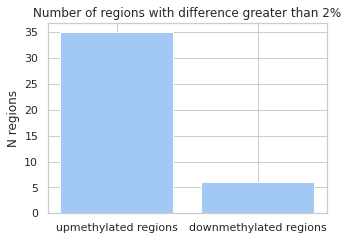

In [87]:
dic = {'upmethylated regions' : 35, 'downmethylated regions' : 6}

sns.set(rc={'figure.figsize':(5, 3.5)}, style='whitegrid')
sns.set_theme(style="whitegrid", palette="pastel")

plt.bar(*zip(*dic.items()))
plt.ylabel("N regions")
plt.title("Number of regions with difference greater than 2%")

### 7. Up- and downmethylated regions

#### 7.1 Upmethylated intervals:

In [33]:
# intervals where methylation level in old age is greater than in young

up_methylated = diff_meth_by_interval.query("old > young")

In [34]:
# number of such intervals

up_methylated.shape[0]

187

In [367]:
up_methylated.head()

Age                   interval        old      young
1    chr10:125984039:125985395  64.130176  62.150000
2    chr10:127832970:127839261  96.675214  91.155000
3    chr10:134515226:134526450  93.772975  93.526651
4      chr10:25459698:25466297   4.523981   3.111883
5      chr10:43717801:43726673   3.367780   2.845616

#### Visualization:

In [35]:
young_up_methylated = young[young["interval"].isin(up_methylated["interval"])]  

In [36]:
old_up_methylated = old[old["interval"].isin(up_methylated["interval"])]  

young average methylation: 84.57426617647059
old average methylation: 85.422790625


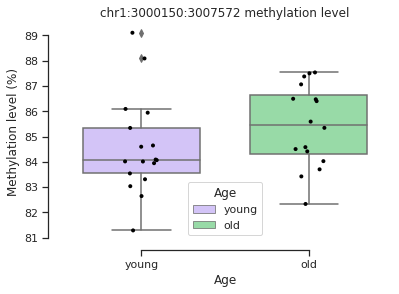

young average methylation: 93.01194599428571
old average methylation: 93.091679876875


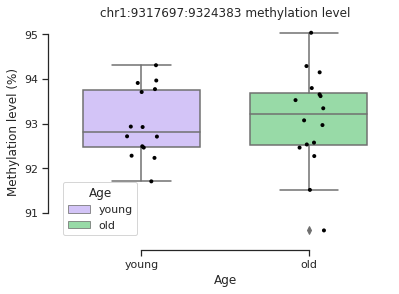

young average methylation: 12.706353571250002
old average methylation: 12.823151260588235


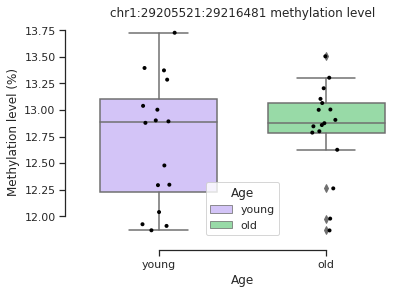

young average methylation: 47.881940714736835
old average methylation: 53.028139283529406


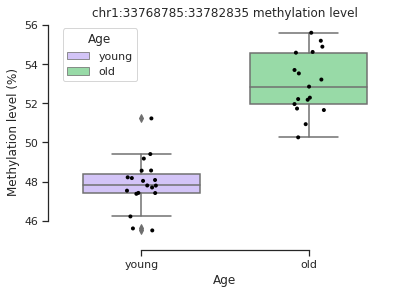

young average methylation: 10.264152751764707
old average methylation: 10.306626882333335


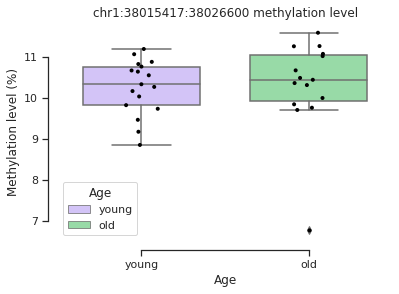

young average methylation: 7.781381538461537
old average methylation: 7.825287142857142


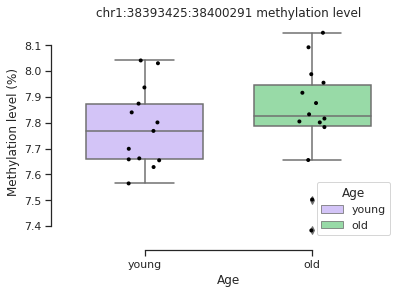

young average methylation: 96.30285416687498
old average methylation: 97.55233333375001


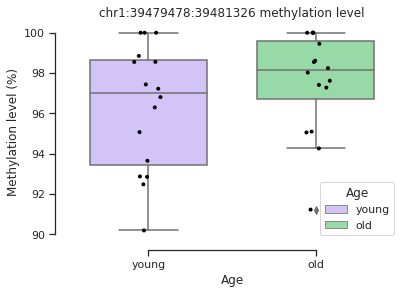

young average methylation: 92.60150892625
old average methylation: 92.79846428625001


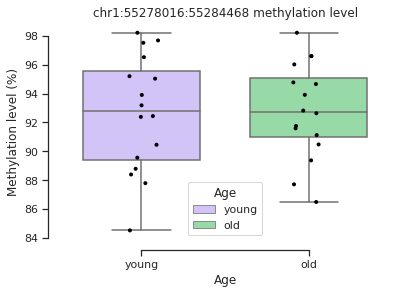

young average methylation: 93.5244358976923
old average methylation: 95.01075555666668


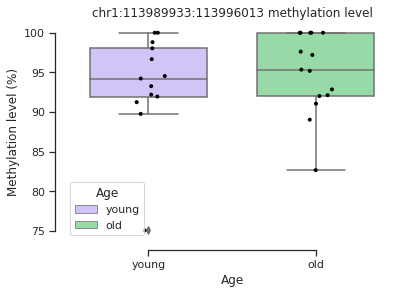

young average methylation: 80.04954364999999
old average methylation: 81.47865820133333


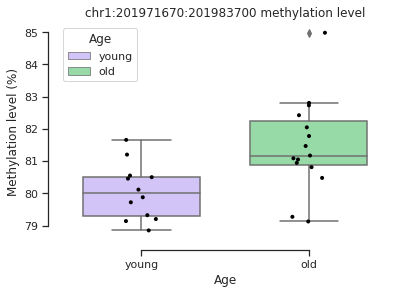

young average methylation: 18.39226597857143
old average methylation: 18.607217543999997


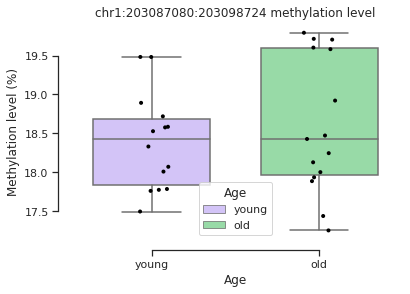

young average methylation: 5.018134012384616
old average methylation: 5.983532171866667


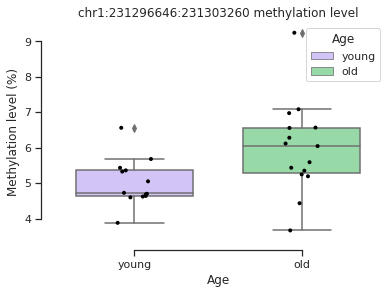

young average methylation: 3.1118832223529402
old average methylation: 4.523980603437501


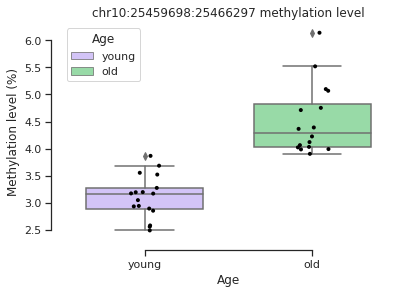

young average methylation: 2.8456157922941174
old average methylation: 3.3677795444117646


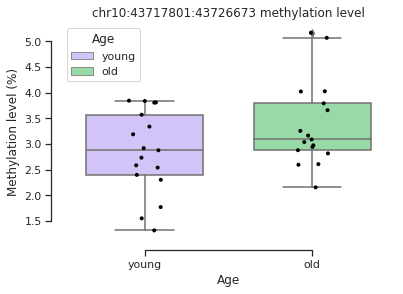

young average methylation: 94.13234050199999
old average methylation: 94.33029109142856


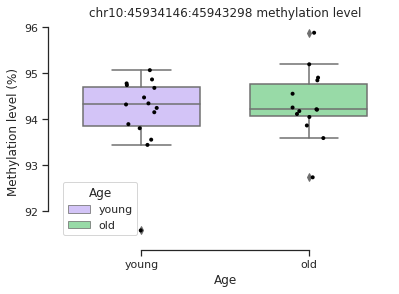

young average methylation: 5.747542307800001
old average methylation: 7.015288461583334


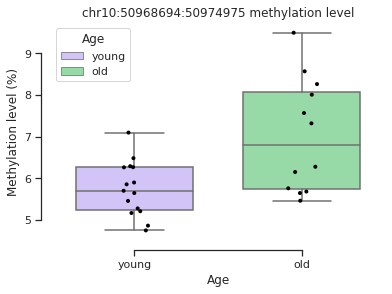

young average methylation: 2.15802645495
old average methylation: 3.2711746032777778


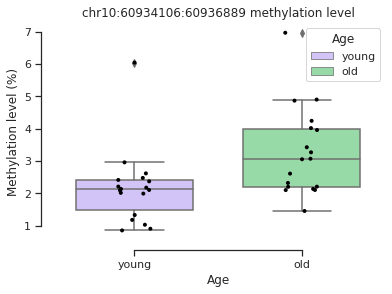

young average methylation: 62.15
old average methylation: 64.13017647058824


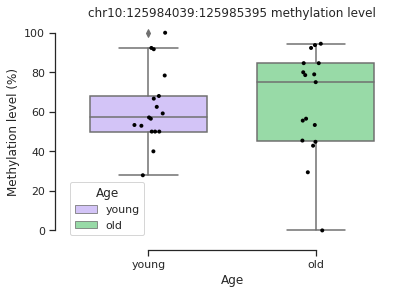

young average methylation: 91.15499999874999
old average methylation: 96.67521428571429


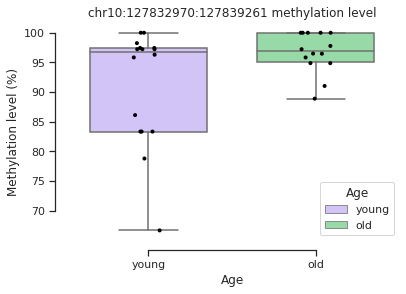

young average methylation: 93.52665133142857
old average methylation: 93.7729752269231


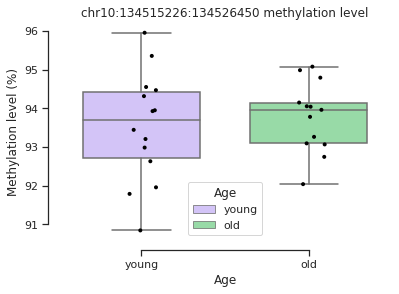

young average methylation: 1.6632175710133335
old average methylation: 1.8416119469999996


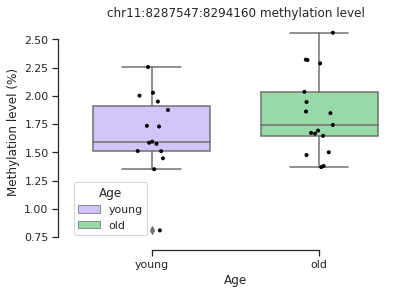

young average methylation: 1.2283080376705884
old average methylation: 2.3139902460555555


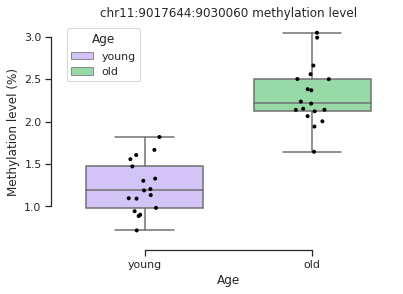

young average methylation: 65.37976716923076
old average methylation: 66.22191271777778


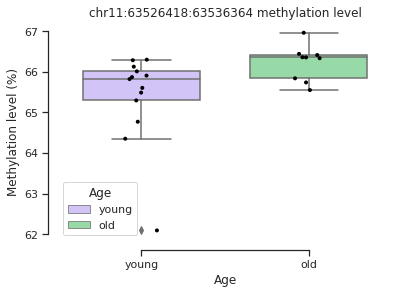

young average methylation: 19.473708147142855
old average methylation: 20.29448535


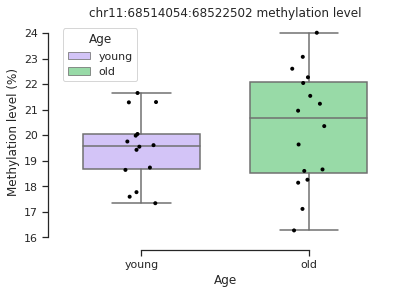

young average methylation: 1.3987212040625
old average methylation: 1.9422729992142858


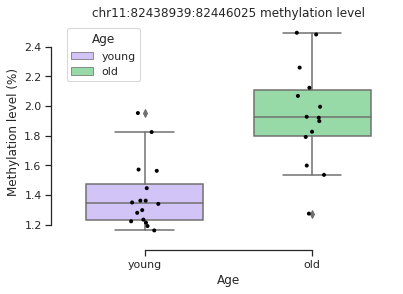

young average methylation: 3.676466386588235
old average methylation: 4.388538903125001


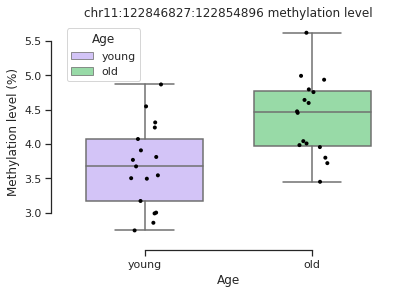

young average methylation: 2.1234599856210523
old average methylation: 4.131175037944445


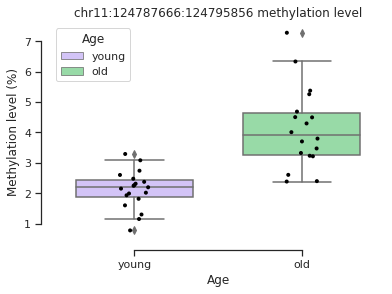

young average methylation: 93.7413529417647
old average methylation: 96.71935238133334


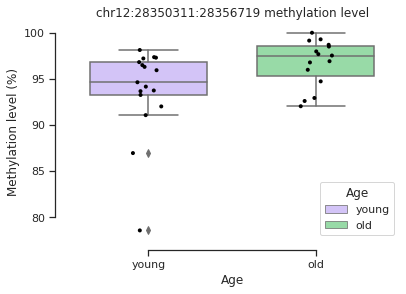

young average methylation: 88.8713409090909
old average methylation: 91.93426785714287


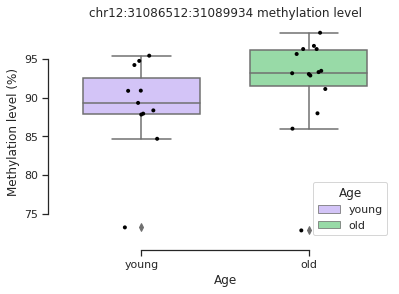

young average methylation: 12.618765636000001
old average methylation: 12.632660530714285


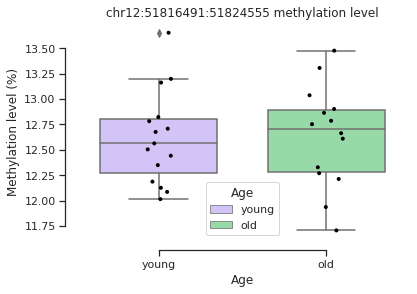

young average methylation: 7.6097336711666665
old average methylation: 7.6797981418125


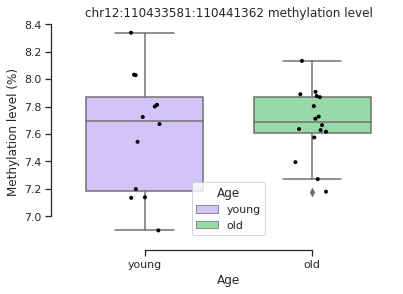

young average methylation: 74.88817777777778
old average methylation: 75.71414117647059


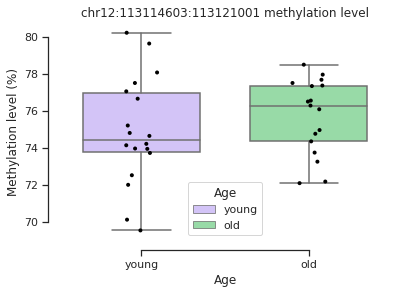

young average methylation: 76.15878888888888
old average methylation: 79.44046666666667


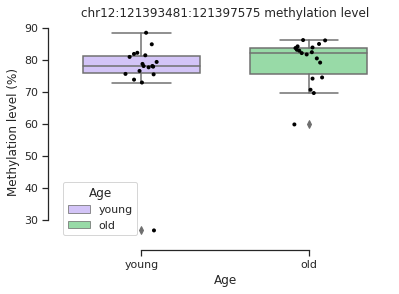

young average methylation: 91.7539602275
old average methylation: 92.31420211062499


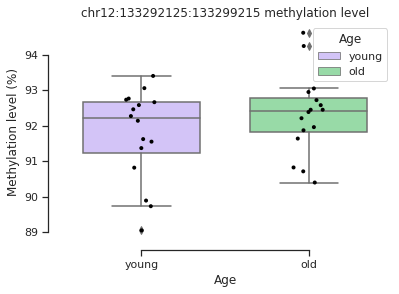

young average methylation: 91.09041777800002
old average methylation: 92.46158666666669


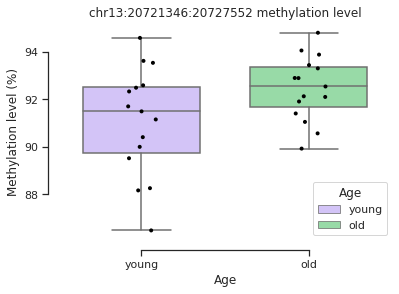

young average methylation: 5.131699790615385
old average methylation: 6.303055372615384


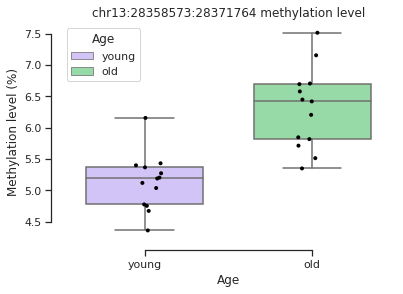

young average methylation: 67.582596590625
old average methylation: 67.81246666733333


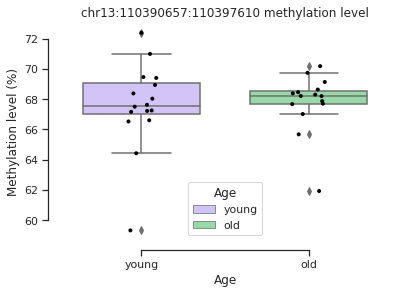

young average methylation: 74.27054166750001
old average methylation: 78.948


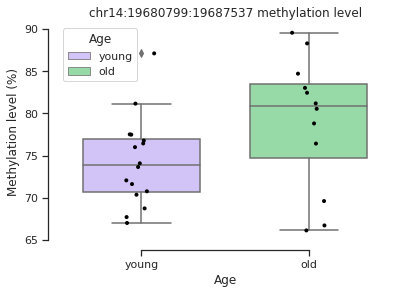

young average methylation: 13.566377778333333
old average methylation: 14.430066665999998


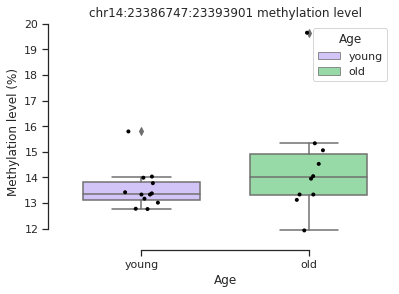

young average methylation: 9.046566310000001
old average methylation: 9.896450169818182


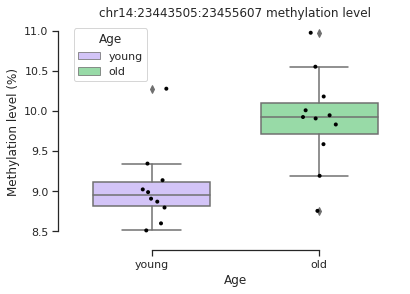

young average methylation: 4.1960911111111105
old average methylation: 6.085296190499999


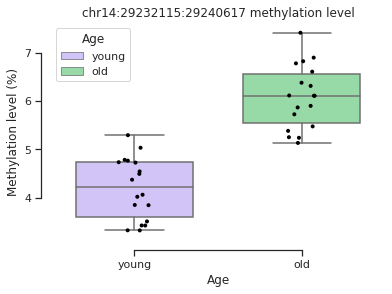

young average methylation: 2.879647916666667
old average methylation: 3.8559343750000004


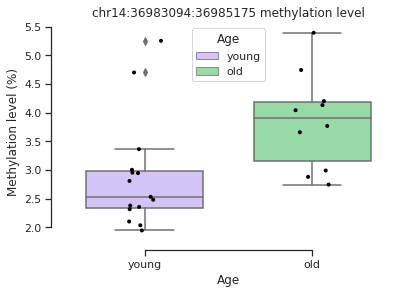

young average methylation: 94.50114492666667
old average methylation: 95.25770902999999


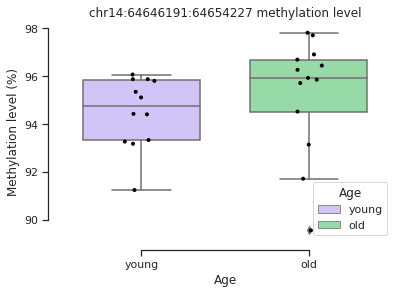

young average methylation: 88.8305
old average methylation: 97.16566666666667


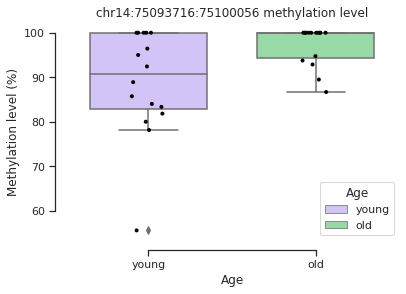

young average methylation: 92.34923611111111
old average methylation: 94.69022222222223


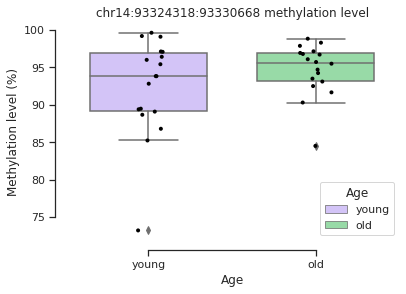

young average methylation: 89.69624188428573
old average methylation: 89.751122728


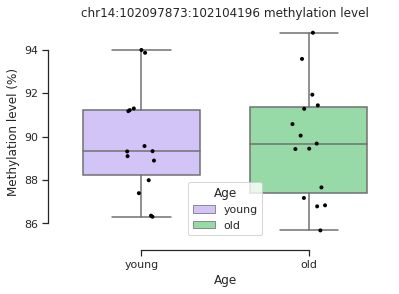

young average methylation: 26.875109258666672
old average methylation: 28.889874182941178


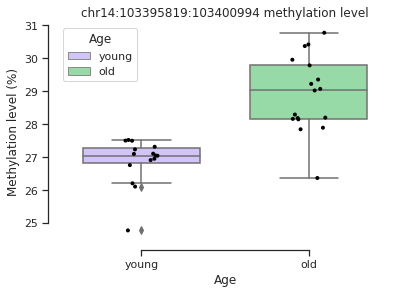

young average methylation: 84.012419046
old average methylation: 86.42273469428572


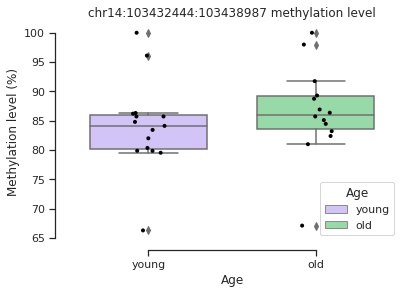

young average methylation: 0.5174537036833333
old average methylation: 0.6235185185166666


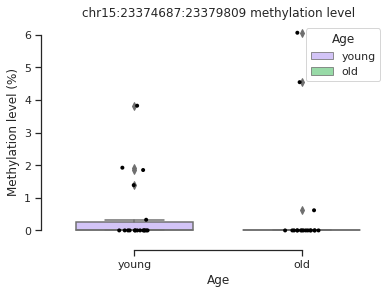

young average methylation: 45.706499997499996
old average methylation: 46.503683231428575


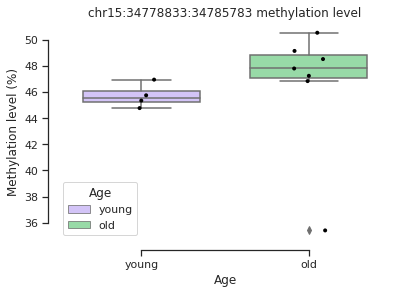

young average methylation: 6.795030864166667
old average methylation: 7.653055555333333


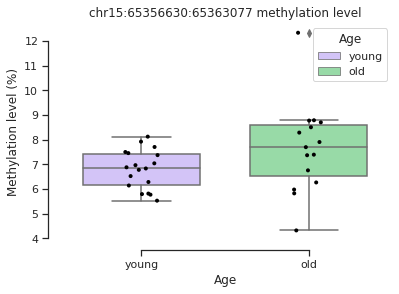

young average methylation: 1.7711017301176473
old average methylation: 2.343456055352941


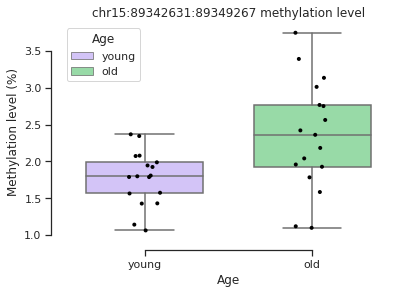

young average methylation: 4.659552197714285
old average methylation: 4.769433333333334


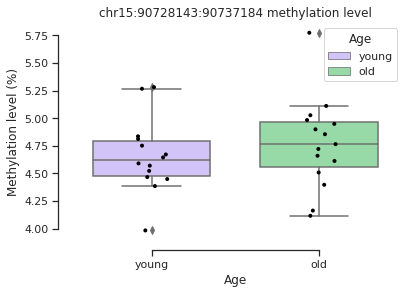

young average methylation: 68.31892941176471
old average methylation: 71.18095625


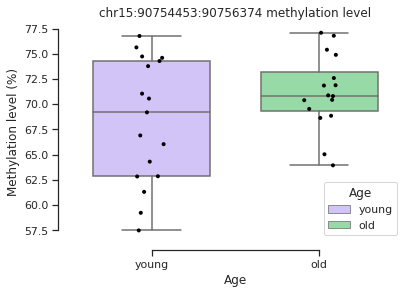

young average methylation: 36.38315555533334
old average methylation: 40.400729166874996


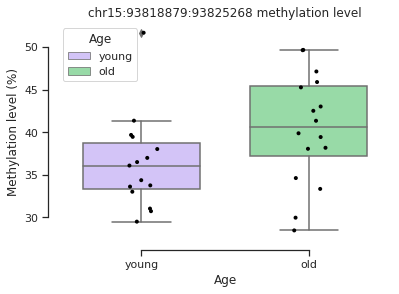

young average methylation: 12.824708014375
old average methylation: 14.486643512857142


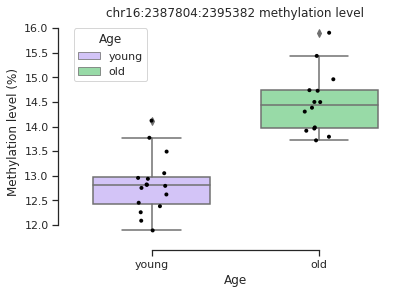

young average methylation: 87.440177083125
old average methylation: 87.76126666533334


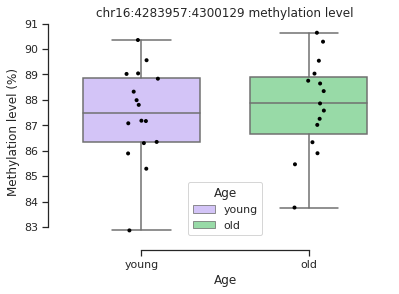

young average methylation: 1.825676609214286
old average methylation: 2.1444678783846154


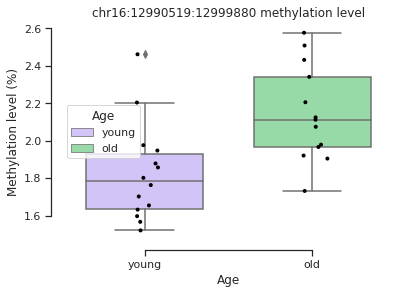

young average methylation: 95.2049375
old average methylation: 95.75435294117648


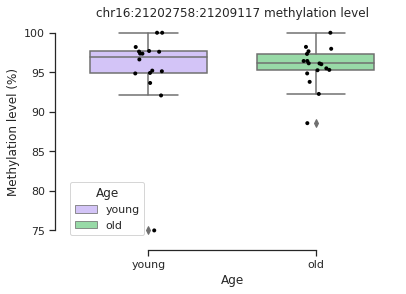

young average methylation: 41.894038304666665
old average methylation: 42.07884017357143


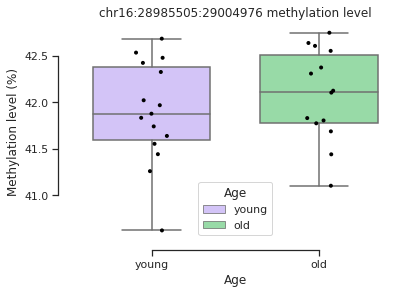

young average methylation: 4.562176954666667
old average methylation: 5.502908641999999


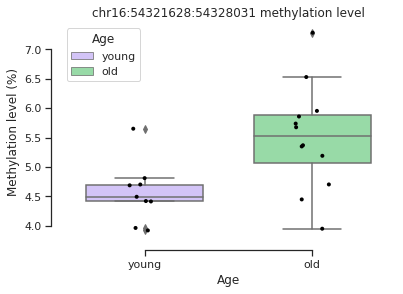

young average methylation: 2.5212365028823527
old average methylation: 2.7327619863124997


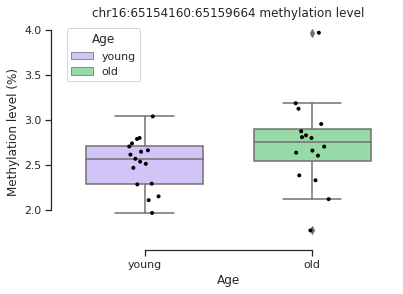

young average methylation: 91.40375241555554
old average methylation: 91.61156288785715


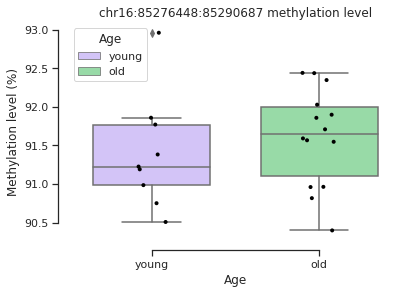

young average methylation: 65.31612857142858
old average methylation: 67.21850714285713


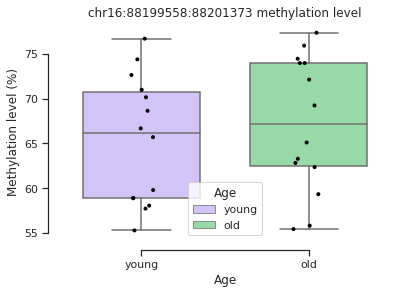

young average methylation: 47.66252069916667
old average methylation: 49.03631399750001


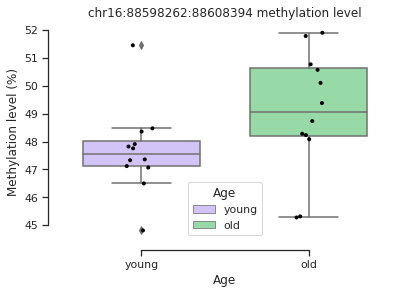

young average methylation: 1.6850226562500001
old average methylation: 1.868490625


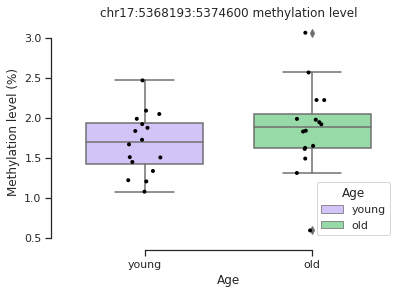

young average methylation: 6.603156288071429
old average methylation: 6.7257804485624995


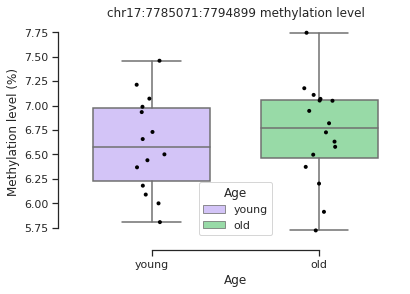

young average methylation: 95.78124489714286
old average methylation: 96.24358035749998


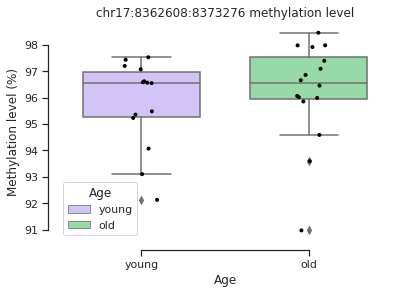

young average methylation: 81.5434794117647
old average methylation: 81.653046875


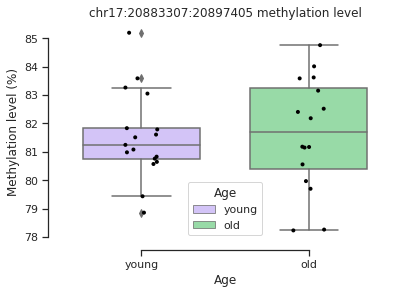

young average methylation: 10.702997938000001
old average methylation: 11.55938620076923


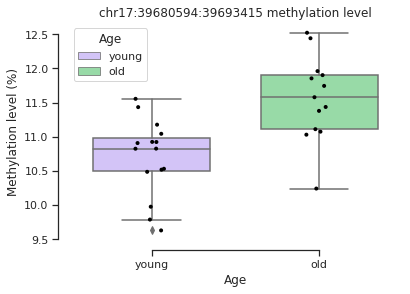

young average methylation: 34.435914045333334
old average methylation: 34.987253210588236


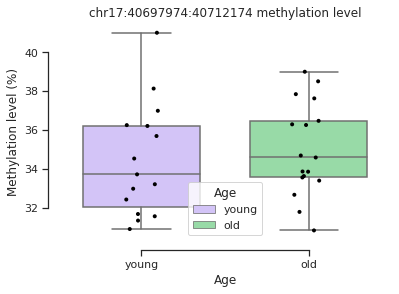

young average methylation: 98.90352631578946
old average methylation: 100.0


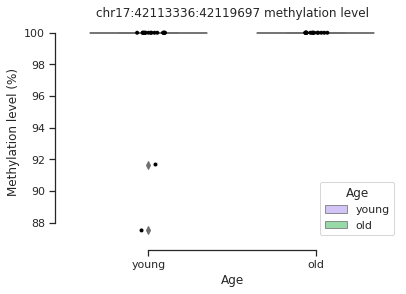

young average methylation: 3.6484614661428574
old average methylation: 3.6754465460625


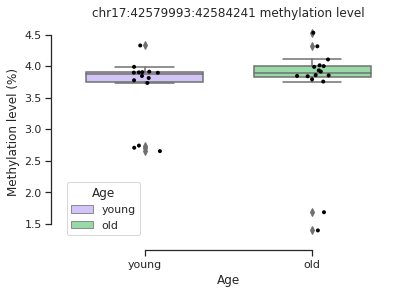

young average methylation: 94.5424
old average methylation: 96.19501176470588


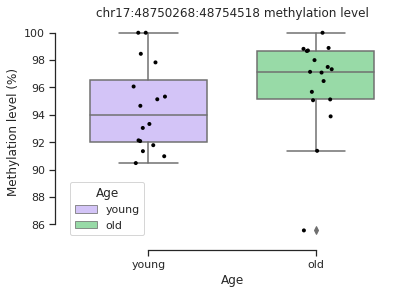

young average methylation: 27.90416518090909
old average methylation: 28.401489108333333


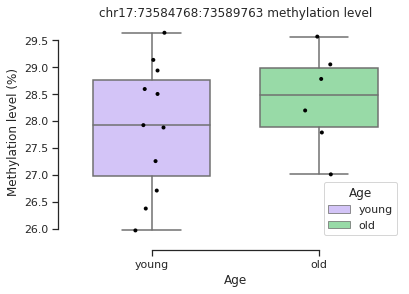

young average methylation: 86.68332198058823
old average methylation: 87.55723976666667


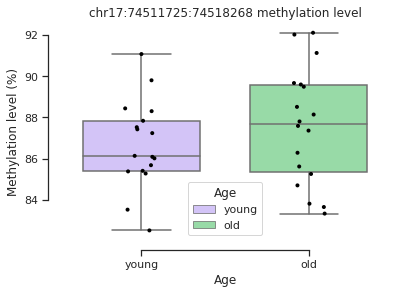

young average methylation: 15.879623168
old average methylation: 15.939569013076921


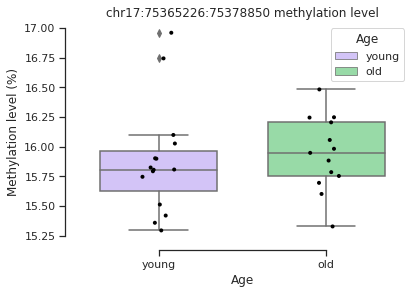

young average methylation: 64.31710740700001
old average methylation: 64.43665319818182


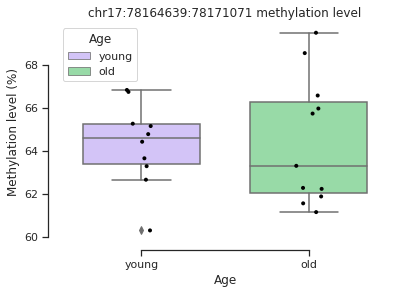

young average methylation: 91.77192857214287
old average methylation: 96.84958823588236


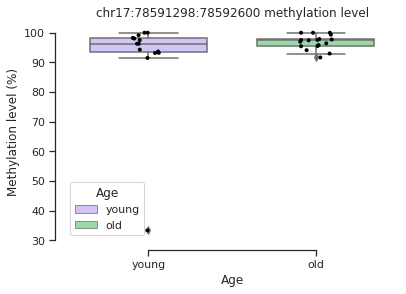

young average methylation: 84.11713194375001
old average methylation: 85.03317156882355


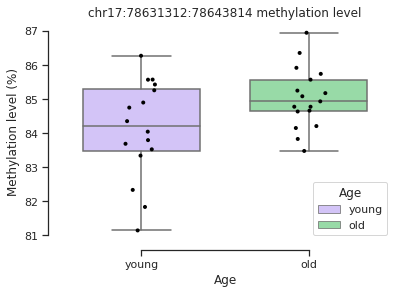

young average methylation: 66.71901075333334
old average methylation: 70.65995066294118


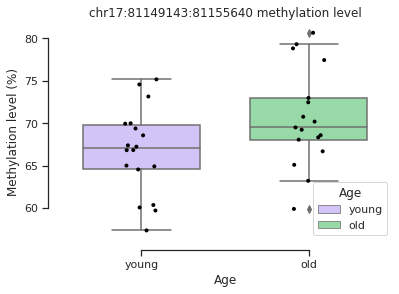

young average methylation: 4.7718429394444435
old average methylation: 6.2643393371875


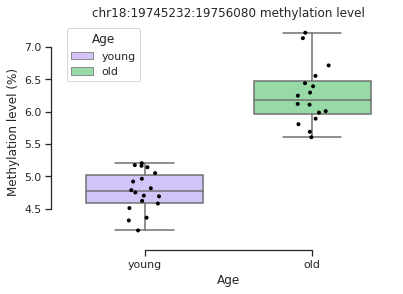

young average methylation: 4.086523448785714
old average methylation: 5.920262626352942


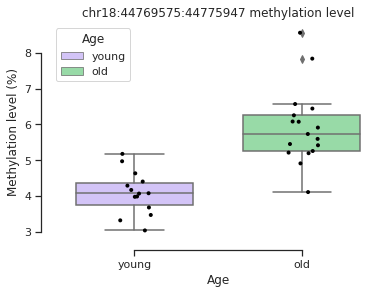

young average methylation: 80.84517249384615
old average methylation: 81.68693506461538


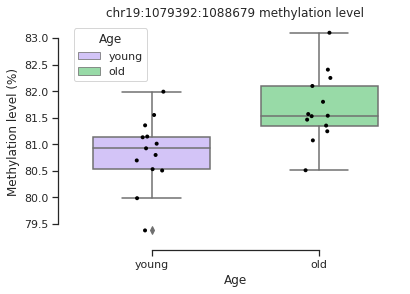

young average methylation: 19.448850171249997
old average methylation: 20.458043664375


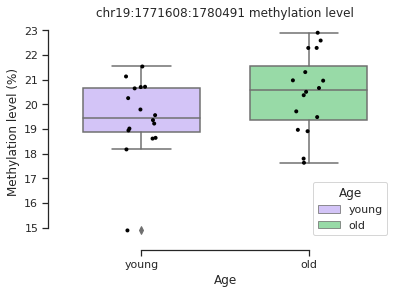

young average methylation: 95.66943337352942
old average methylation: 95.71576984111113


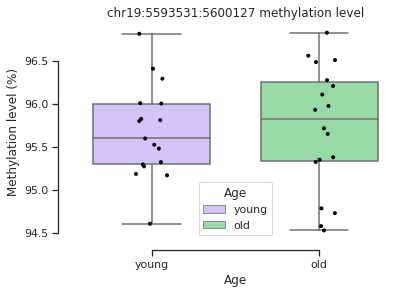

young average methylation: 43.119105978125006
old average methylation: 43.2886691575


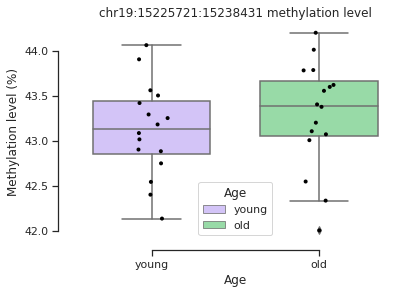

young average methylation: 87.00317658833335
old average methylation: 87.7089682538889


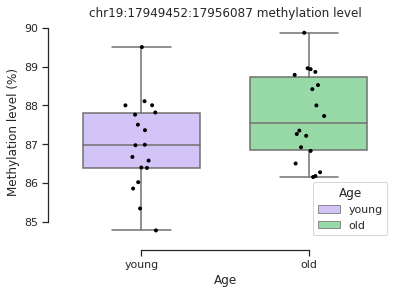

young average methylation: 91.90924999999999
old average methylation: 97.40373333333334


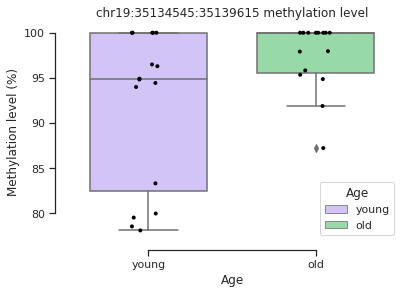

young average methylation: 1.0312584459125
old average methylation: 1.5146717011117647


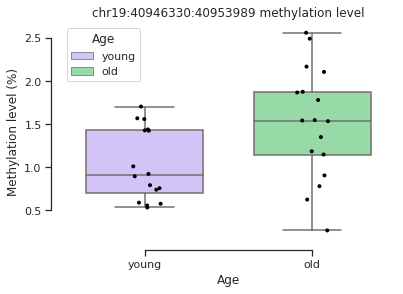

young average methylation: 39.716941299090905
old average methylation: 40.36548395538461


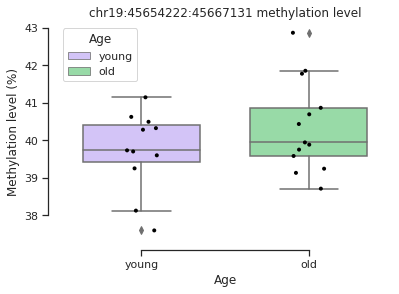

young average methylation: 80.79681808294117
old average methylation: 81.76768402750001


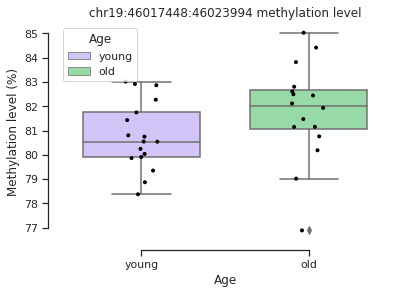

young average methylation: 3.5279531248750002
old average methylation: 3.5503907563529413


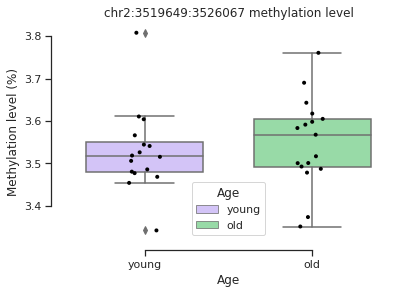

young average methylation: 93.94254761928572
old average methylation: 94.57876767727272


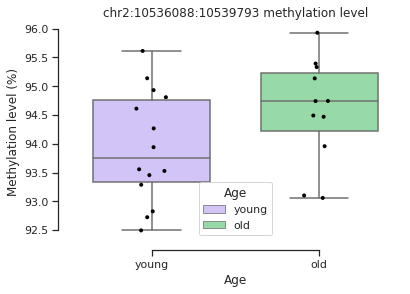

young average methylation: 75.883
old average methylation: 88.77541666666666


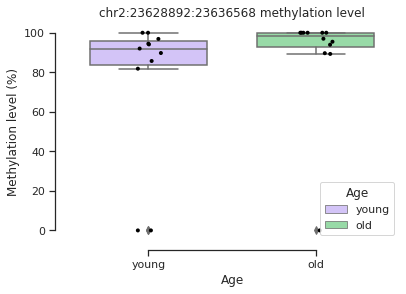

young average methylation: 94.14434374999999
old average methylation: 95.0910357142857


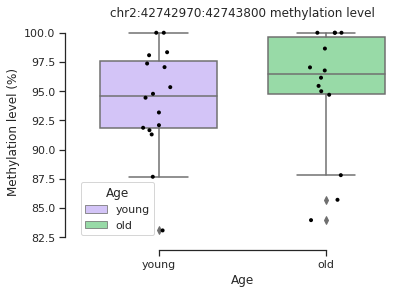

young average methylation: 10.465277530249999
old average methylation: 10.739994897857143


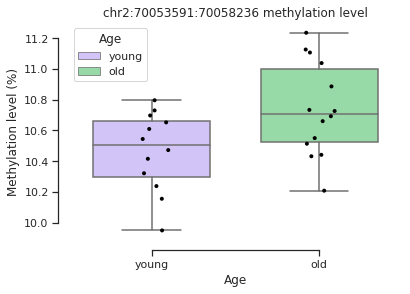

young average methylation: 92.37020588235293
old average methylation: 93.38234374999999


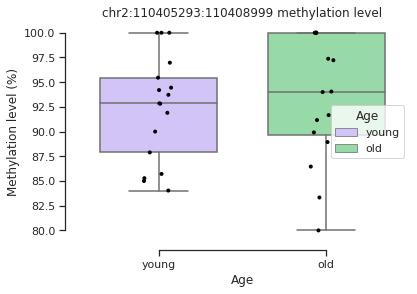

young average methylation: 5.7818422255
old average methylation: 6.373901626066667


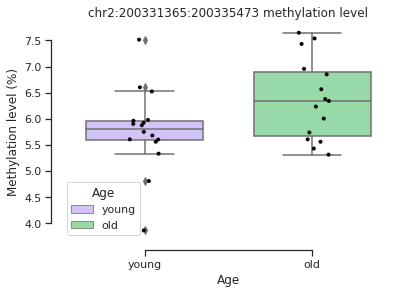

young average methylation: 20.187277969285713
old average methylation: 20.24290857529412


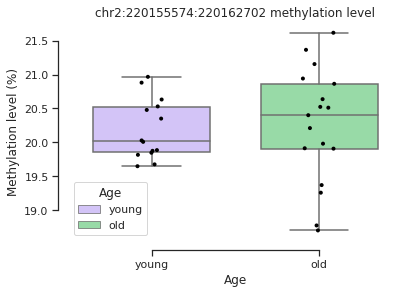

young average methylation: 7.9109311975
old average methylation: 7.963990686333334


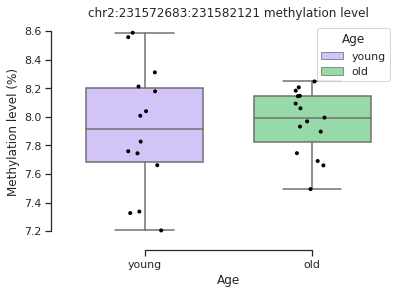

young average methylation: 69.25698148111111
old average methylation: 71.85809953625


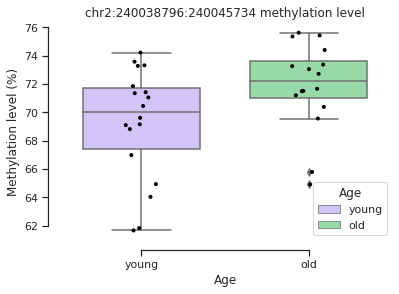

young average methylation: 1.499241242647059
old average methylation: 1.620046348375


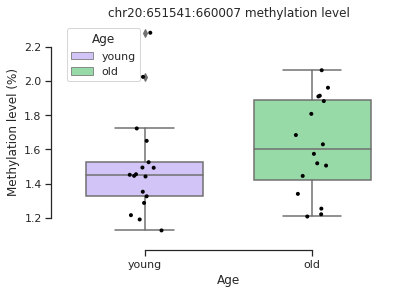

young average methylation: 84.54054783833334
old average methylation: 84.67451111133333


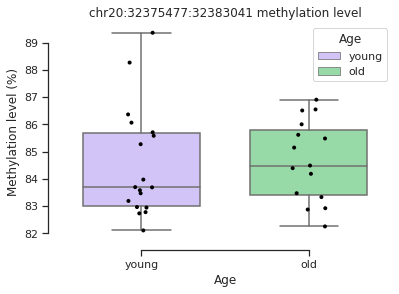

young average methylation: 13.46029343894737
old average methylation: 16.98741324111111


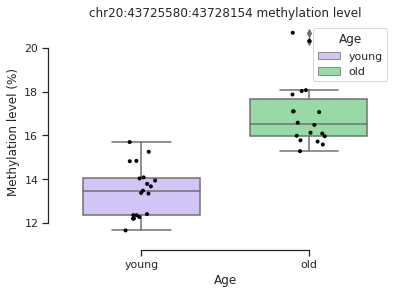

young average methylation: 83.86323333333333
old average methylation: 86.26270588235293


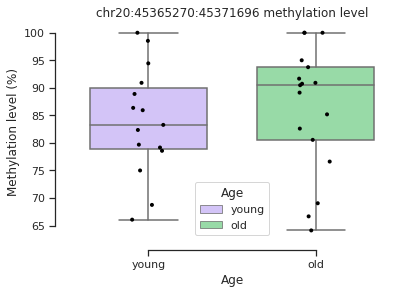

young average methylation: 2.784936651658824
old average methylation: 4.477398189929411


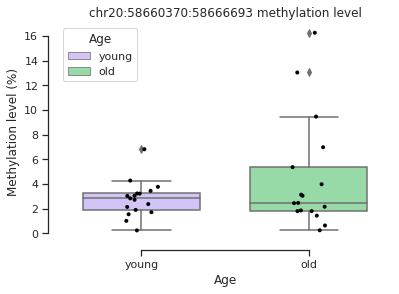

young average methylation: 79.12037931142858
old average methylation: 79.44886853500002


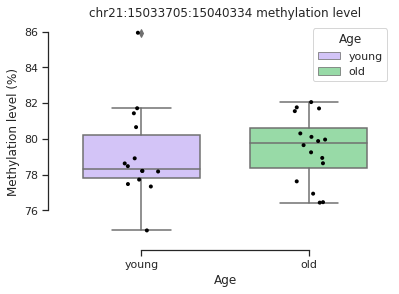

young average methylation: 85.63935294117648
old average methylation: 87.29008333333334


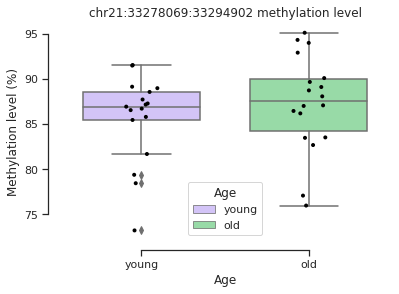

young average methylation: 91.48436666666667
old average methylation: 92.14682666666667


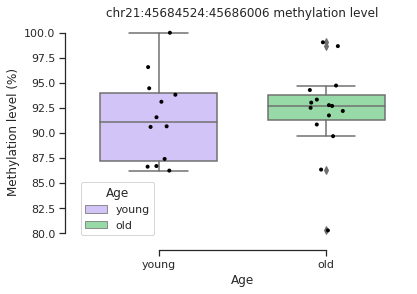

young average methylation: 93.91180392117647
old average methylation: 94.9912063492857


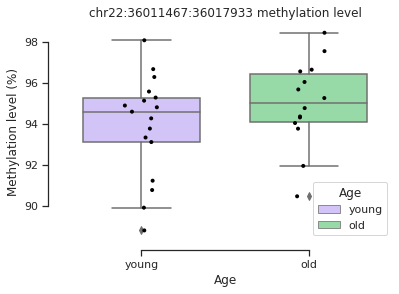

young average methylation: 86.77574789882354
old average methylation: 87.1450336135294


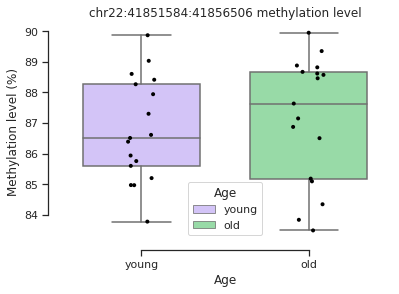

young average methylation: 81.614694445
old average methylation: 82.03491358166667


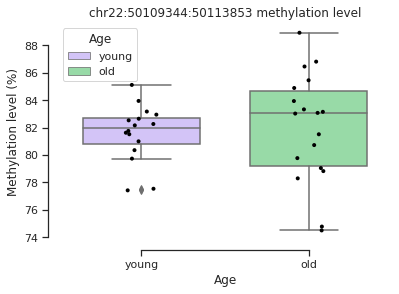

young average methylation: 43.510471501666665
old average methylation: 45.87169706466667


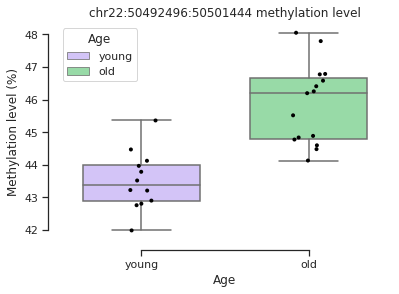

young average methylation: 69.65017454
old average methylation: 71.306010080625


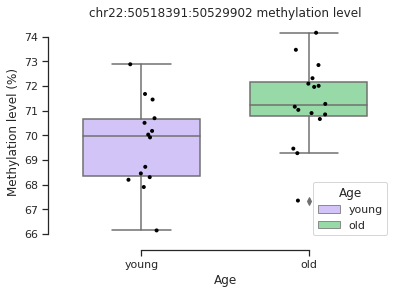

young average methylation: 82.46837948923077
old average methylation: 84.21763077


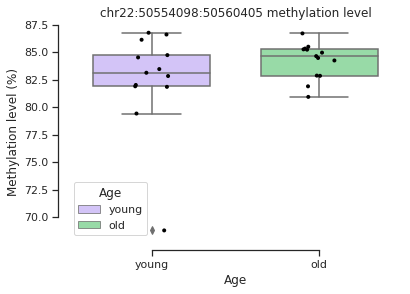

young average methylation: 77.19369412812499
old average methylation: 78.53948557


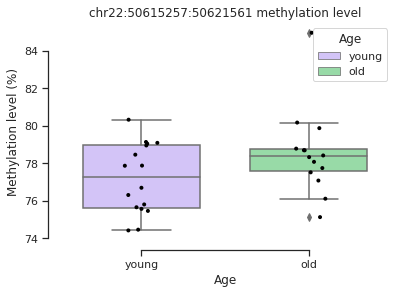

young average methylation: 6.632119514470588
old average methylation: 7.403947496923077


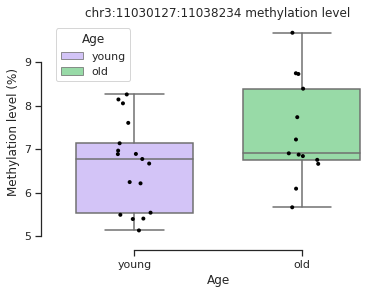

young average methylation: 23.31645785388889
old average methylation: 43.125149426111115


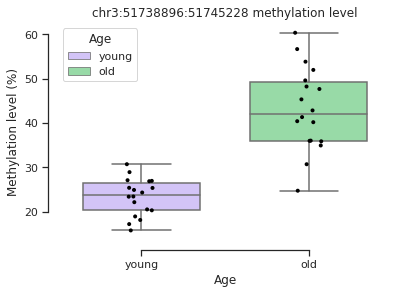

young average methylation: 30.755434949374997
old average methylation: 35.047013205294114


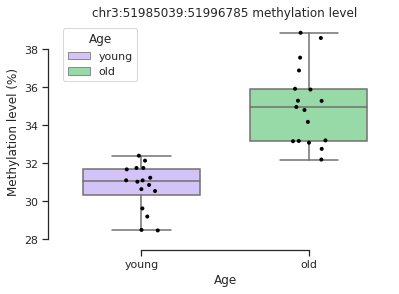

young average methylation: 0.56952894737
old average methylation: 1.018802905675


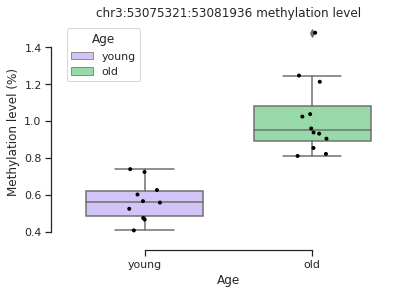

young average methylation: 91.9531818188889
old average methylation: 92.62099350642859


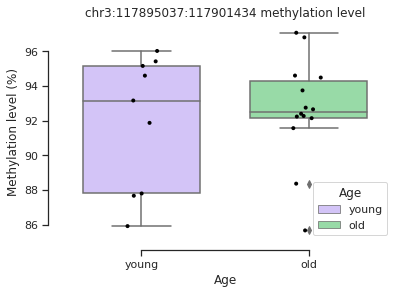

young average methylation: 1.191695471129412
old average methylation: 1.3189687315066665


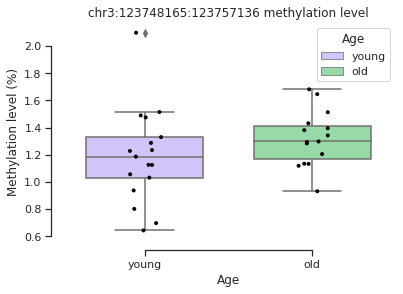

young average methylation: 1.1809506848466669
old average methylation: 1.4285662801538461


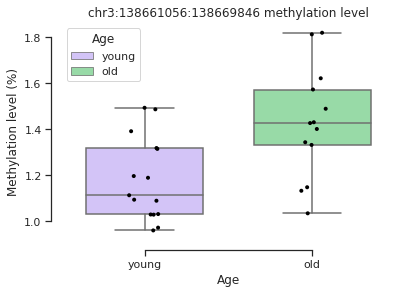

young average methylation: 96.92678703777779
old average methylation: 97.08198774411764


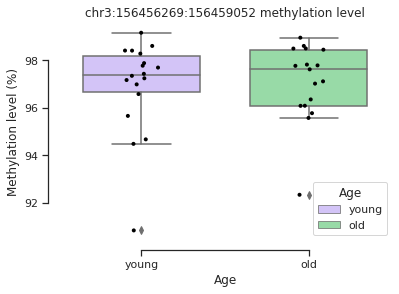

young average methylation: 93.94725
old average methylation: 94.67423333333333


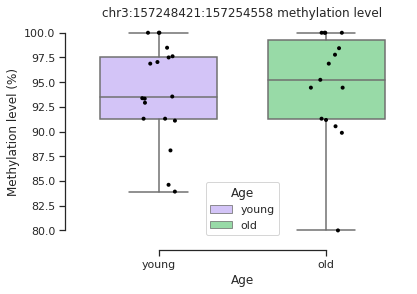

young average methylation: 74.932375
old average methylation: 78.90723529294118


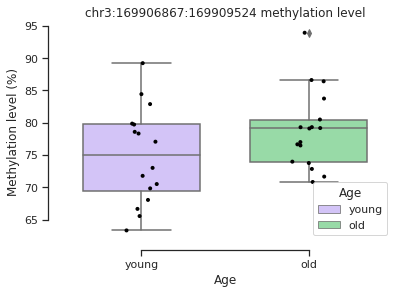

young average methylation: 77.398875
old average methylation: 87.7005625


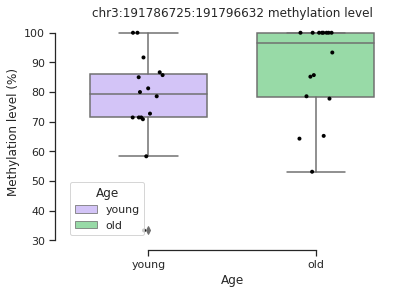

young average methylation: 88.30989751571428
old average methylation: 89.98772378470586


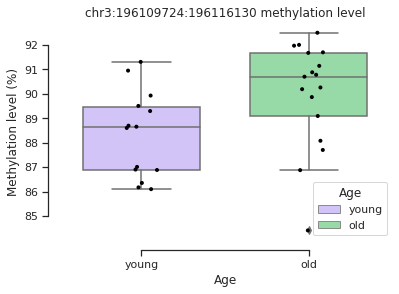

young average methylation: 16.318955182941174
old average methylation: 16.373518208235296


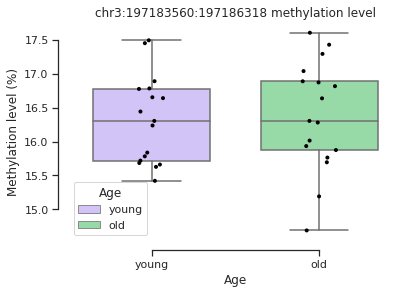

young average methylation: 35.18590423916666
old average methylation: 35.60097017533334


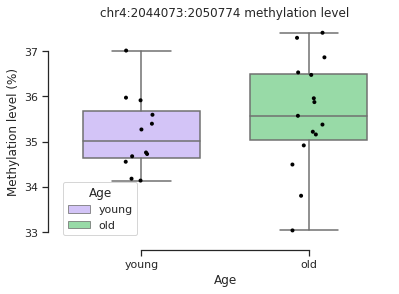

young average methylation: 5.680746936374999
old average methylation: 6.6815846406


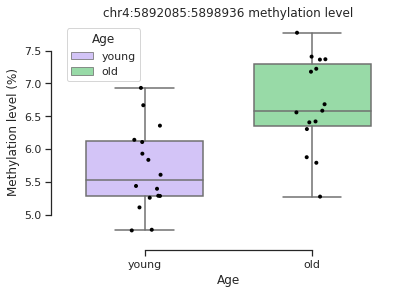

young average methylation: 36.94202389624999
old average methylation: 39.76819853


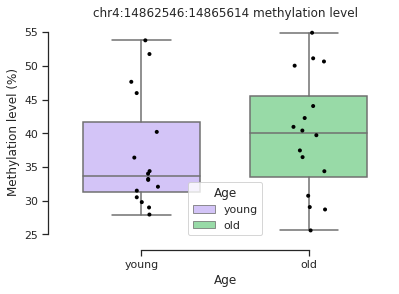

young average methylation: 7.39956947368421
old average methylation: 9.911786666666666


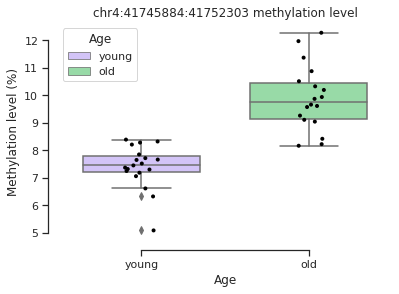

young average methylation: 10.204909219600001
old average methylation: 10.349246808666665


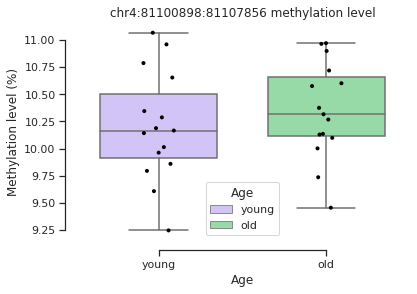

young average methylation: 4.345286239888889
old average methylation: 6.6013883910588245


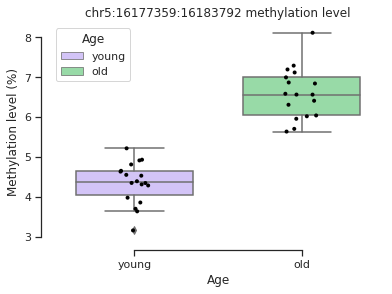

young average methylation: 7.119925411071429
old average methylation: 7.518044928538462


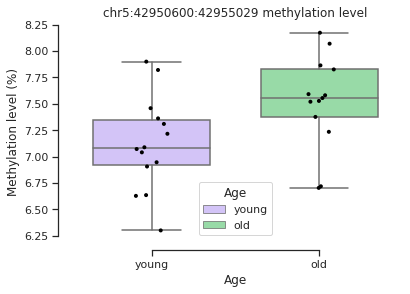

young average methylation: 1.169891812888889
old average methylation: 1.7570216717529414


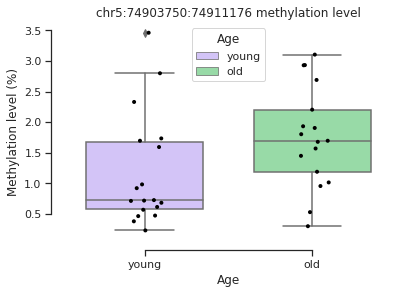

young average methylation: 93.784415585
old average methylation: 94.83919480571429


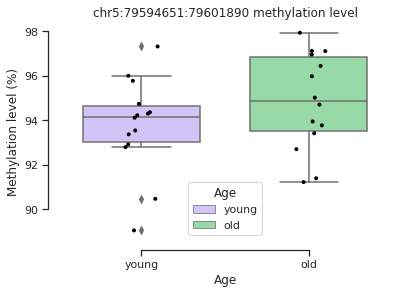

young average methylation: 2.1392510017333337
old average methylation: 2.449526737


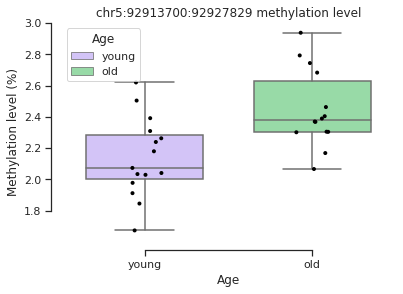

young average methylation: 75.791197916875
old average methylation: 79.89327380857144


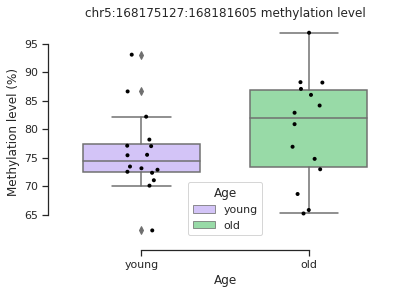

young average methylation: 7.895751973625001
old average methylation: 8.442413333266666


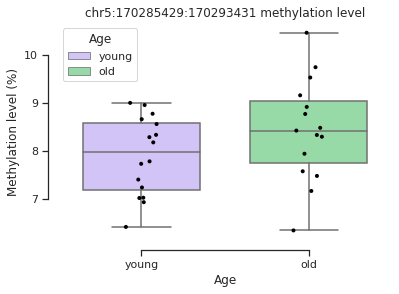

young average methylation: 2.1661616222142857
old average methylation: 2.2184801173846154


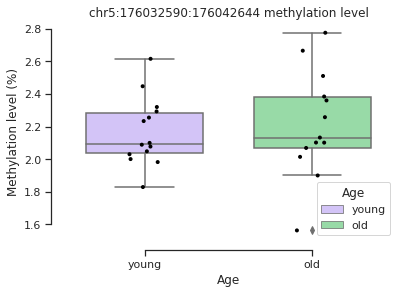

young average methylation: 0.29857037036
old average methylation: 0.3805370370333333


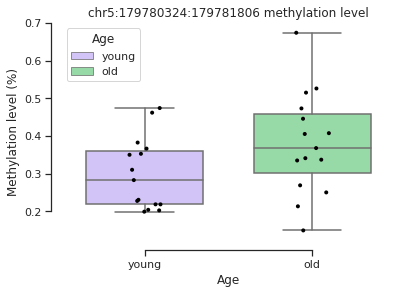

young average methylation: 92.03891315076922
old average methylation: 92.06699999933335


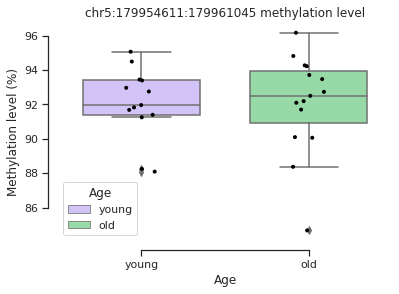

young average methylation: 91.11519951923076
old average methylation: 92.768484375


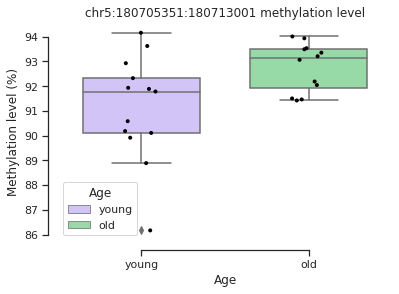

young average methylation: 0.08056978022384616
old average methylation: 0.17857551019714285


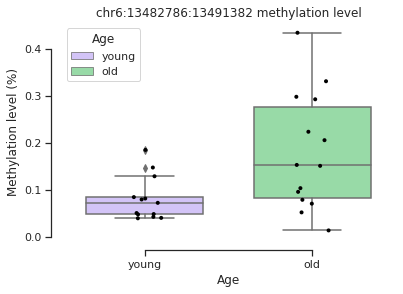

young average methylation: 48.343973684210525
old average methylation: 50.310264705882354


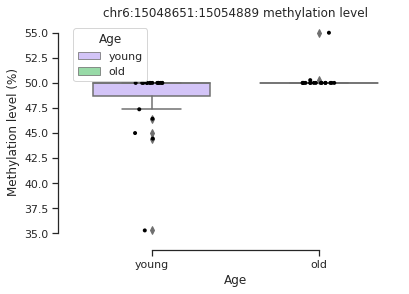

young average methylation: 95.2647912076923
old average methylation: 95.7702967023077


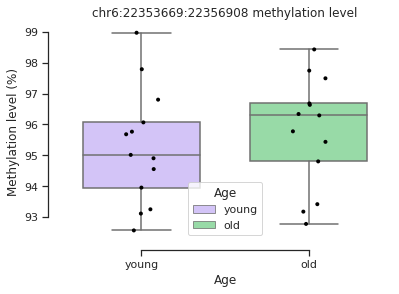

young average methylation: 0.10667515151466668
old average methylation: 0.18260129869785716


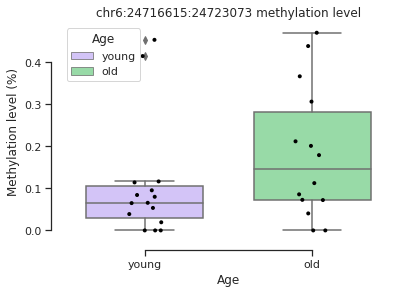

young average methylation: 1.4886798756666666
old average methylation: 1.5522487512142857


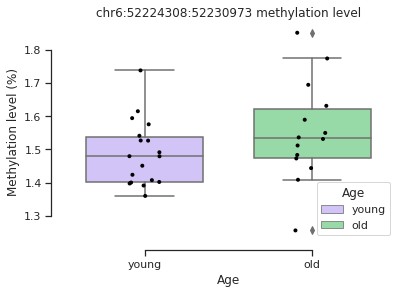

young average methylation: 2.558989151846154
old average methylation: 3.0097051282666665


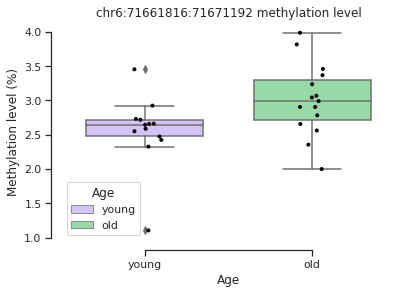

young average methylation: 92.45886666666667
old average methylation: 95.62275000000001


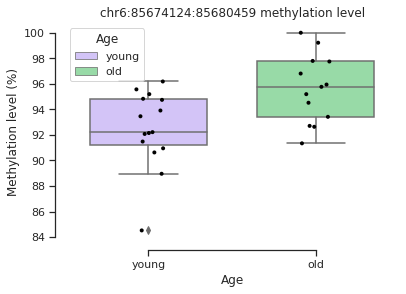

young average methylation: 5.402257352933333
old average methylation: 6.7530739890625


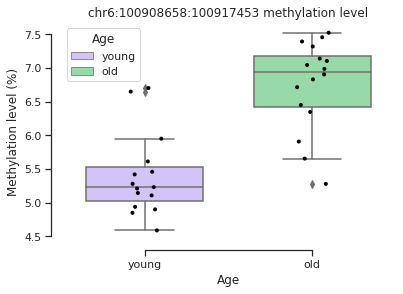

young average methylation: 87.30678231285717
old average methylation: 88.61880403


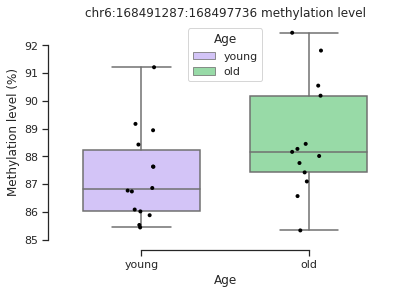

young average methylation: 90.5819775507143
old average methylation: 91.39508571384616


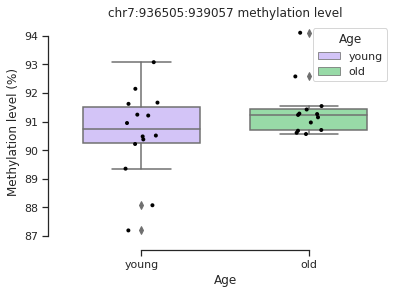

young average methylation: 95.04882500000001
old average methylation: 95.81107666666666


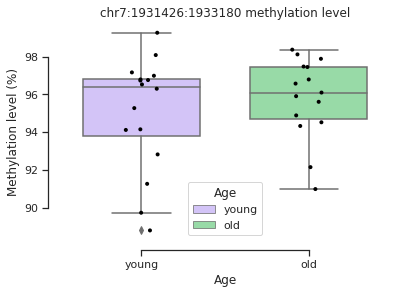

young average methylation: 85.42635853
old average methylation: 86.51079889


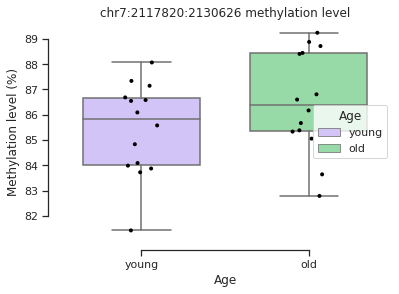

young average methylation: 0.09838285714714287
old average methylation: 0.111872666653


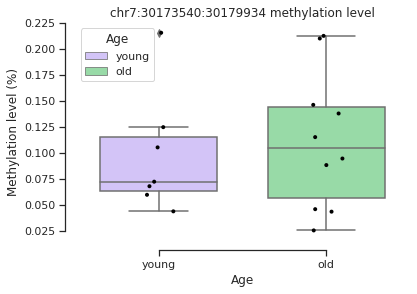

young average methylation: 5.024761609882353
old average methylation: 5.173471620176471


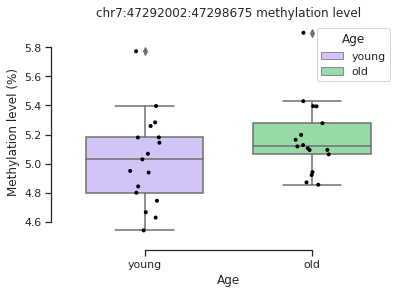

young average methylation: 76.77185416666666
old average methylation: 76.77780288461538


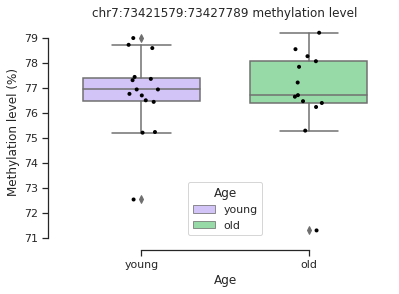

young average methylation: 96.97888235294118
old average methylation: 97.4693125


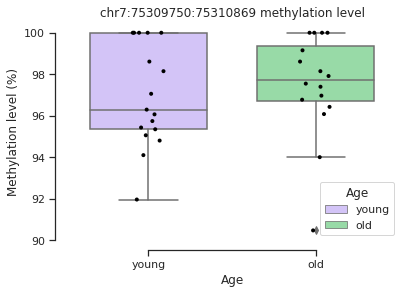

young average methylation: 49.61844276647058
old average methylation: 69.34744819833332


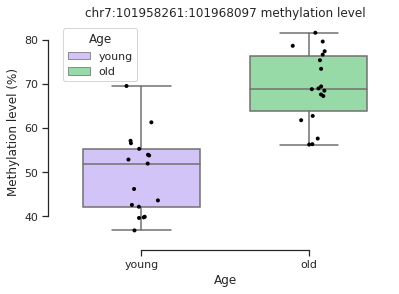

young average methylation: 0.08639682540444443
old average methylation: 0.09790756302333334


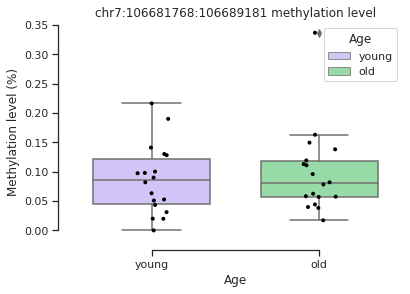

young average methylation: 0.46495144312105263
old average methylation: 0.8835218216882352


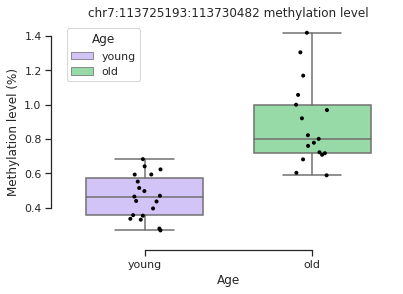

young average methylation: 0.12926097762941177
old average methylation: 0.16501988400705883


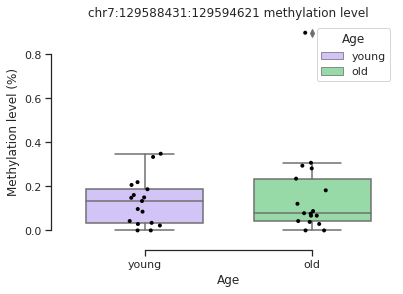

young average methylation: 81.54810553187501
old average methylation: 81.56731785166667


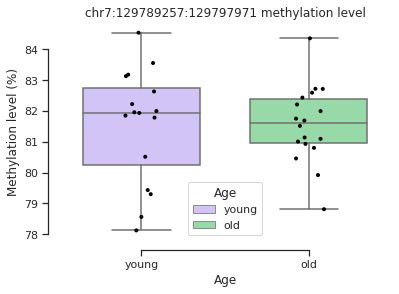

young average methylation: 88.41004977470588
old average methylation: 89.12502350444446


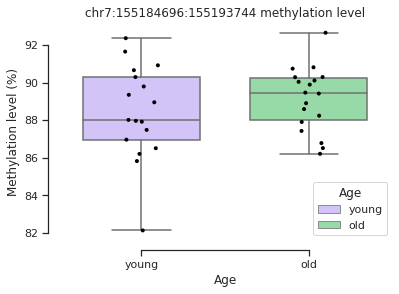

young average methylation: 90.76205714285716
old average methylation: 93.31610666666667


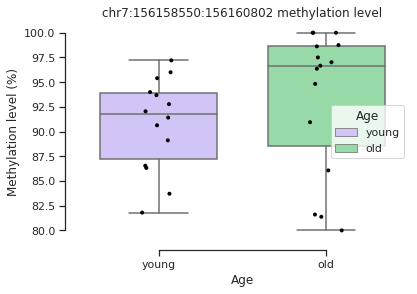

young average methylation: 94.94288235294118
old average methylation: 95.72800980470588


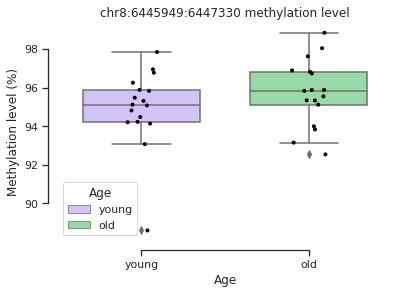

young average methylation: 17.940625
old average methylation: 24.375600000000002


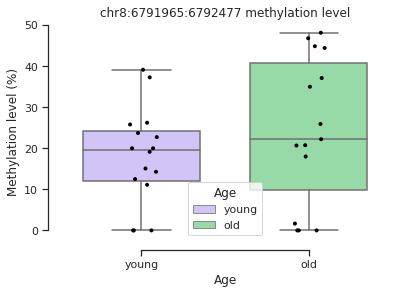

young average methylation: 92.64412499999999
old average methylation: 94.32195833333333


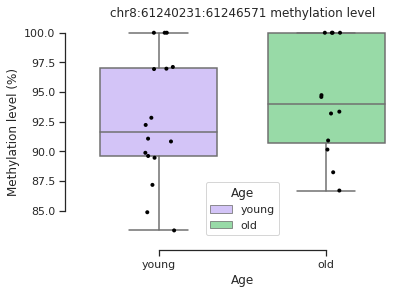

young average methylation: 0.1319621913477778
old average methylation: 0.15149836600588235


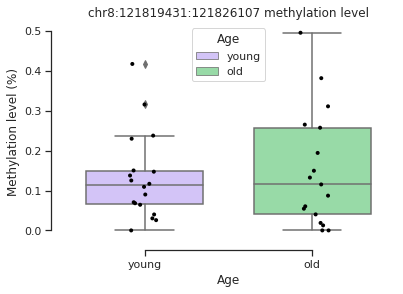

young average methylation: 89.10165010117646
old average methylation: 89.2222090525


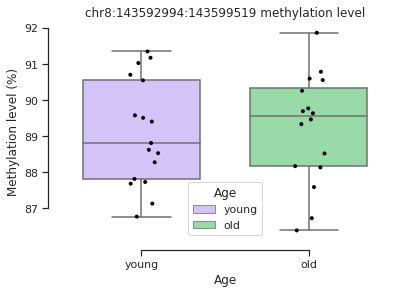

young average methylation: 78.12468650714287
old average methylation: 78.83308289285715


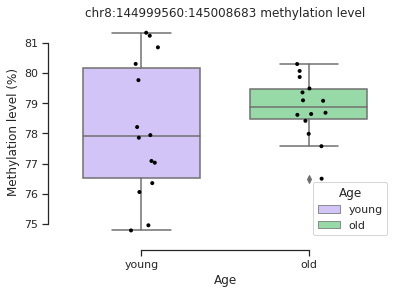

young average methylation: 25.880701380909088
old average methylation: 26.72111407615385


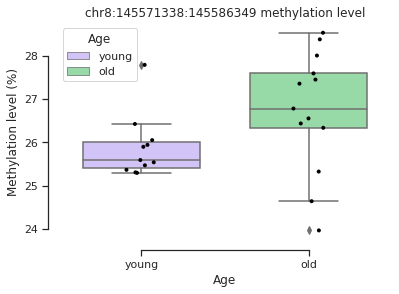

young average methylation: 2.2952037037222226
old average methylation: 2.7921814815555552


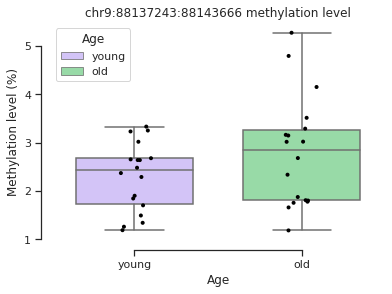

young average methylation: 96.26261607125001
old average methylation: 96.38420535625


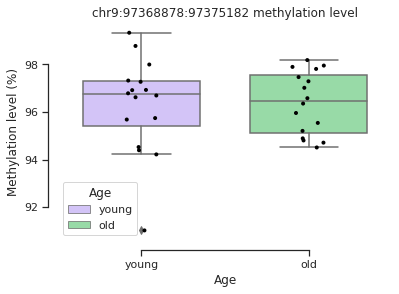

young average methylation: 24.098847918750003
old average methylation: 24.693794444444443


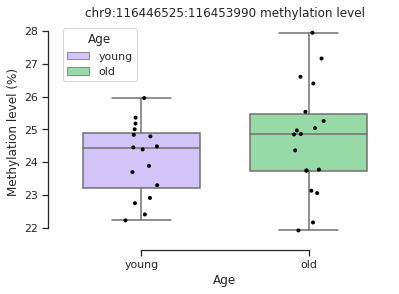

young average methylation: 86.22758796277778
old average methylation: 86.2456171875


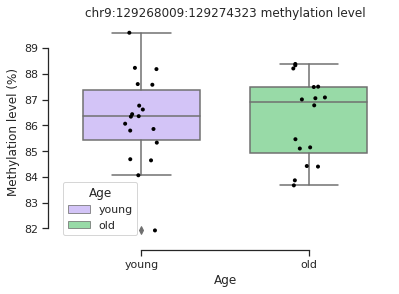

young average methylation: 93.77247079066665
old average methylation: 93.814351159375


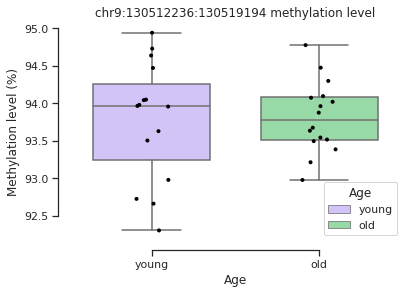

young average methylation: 86.399749999375
old average methylation: 87.14520588176471


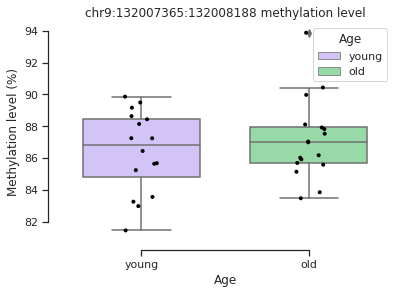

young average methylation: 3.0317336395384618
old average methylation: 3.1108563432500005


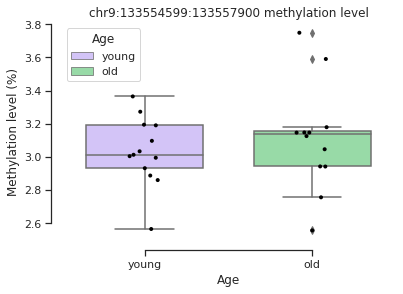

young average methylation: 23.14195948375
old average methylation: 26.04818128214286


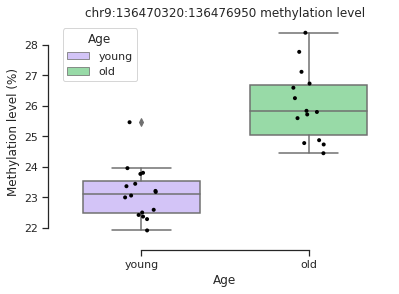

young average methylation: 73.06633082714286
old average methylation: 73.97684912266668


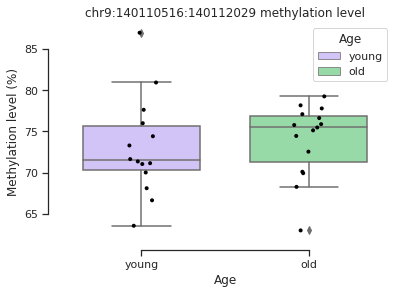

young average methylation: 69.78249999944444
old average methylation: 72.96203086500002


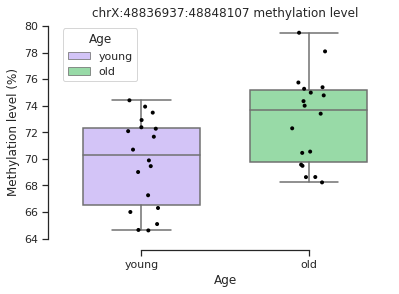

young average methylation: 9.062999548277778
old average methylation: 10.784985653764707


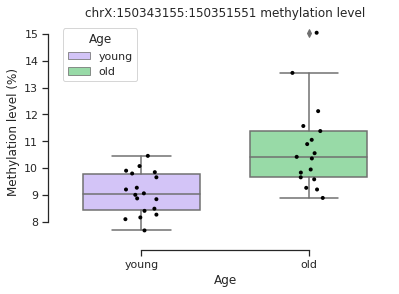

In [37]:
for interval in young_up_methylated["interval"]:
    a = young_up_methylated.query('interval == @interval')
    b = old_up_methylated.query('interval == @interval')
    c = pd.concat([a.assign(Age='young'), b.assign(Age='old')])
    c = c.drop([0, 1, 2], axis=1)
    d = pd.melt(c, id_vars=['Age', 'interval'])
    
    print('young average methylation: ' + str(d.query('Age == "young"')["value"].mean()))
    print('old average methylation: ' + str(d.query('Age == "old"')["value"].mean()))
    
    sns.set(rc={'figure.figsize':(6, 4)}, style='whitegrid')
    sns.set_theme(style="ticks", palette="pastel")    
    
    sns.boxplot(x="Age", hue="Age", y="value", data=d, palette=["m", "g"], width=0.7, dodge=False).set_title("{} methylation level".format(interval))
    sns.stripplot(x="Age", y="value", data=d, color='black', s=4)
    sns.despine(offset=10, trim=True)
    plt.ylabel("Methylation level (%)")
    plt.show()

#### 7.2 Downmethylated intervals:

In [38]:
# intervals where methylation level in old age is lower than in young

down_methylated = diff_meth_by_interval.query("young > old")

In [39]:
# number of such intervals

down_methylated.shape[0]

74

In [372]:
down_methylated.head()

Age                   interval        old      young
0    chr10:118461288:118462256  91.476521  92.193578
9      chr10:71072671:71079200   0.181130   0.208316
10     chr10:81175501:81180668  75.592187  75.862046
11   chr11:116214221:116221632  91.109333  94.101593
14   chr11:126393373:126401030  87.784755  88.883779

#### Visualization:

In [40]:
young_down_methylated = young[young["interval"].isin(down_methylated["interval"])]

In [41]:
old_down_methylated = old[old["interval"].isin(down_methylated["interval"])]

young average methylation: 96.8620390625
old average methylation: 95.71507352941177


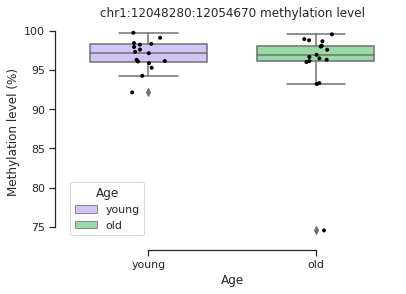

young average methylation: 93.97626250000002
old average methylation: 93.8907


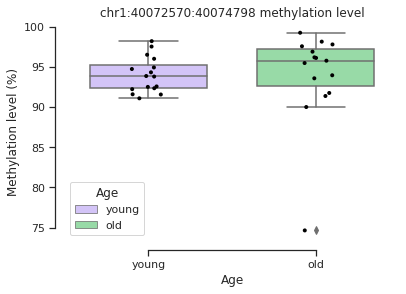

young average methylation: 1.3802153845333331
old average methylation: 1.2691850960062498


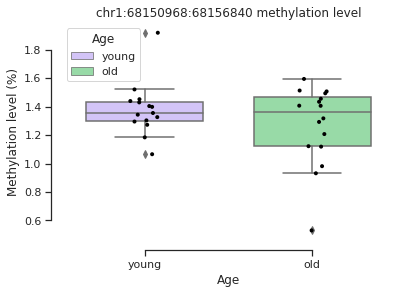

young average methylation: 92.54434910470587
old average methylation: 91.79023505499998


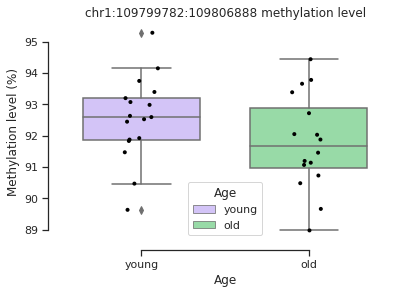

young average methylation: 95.62477333333332
old average methylation: 95.15948235294118


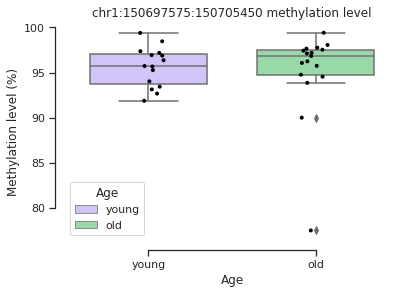

young average methylation: 92.08401176470588
old average methylation: 91.5608


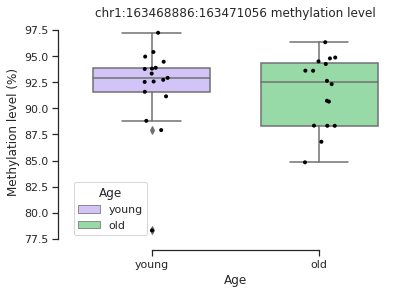

young average methylation: 36.05513580277778
old average methylation: 35.91334362166667


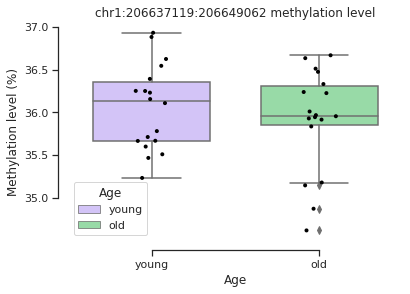

young average methylation: 86.48386274411764
old average methylation: 86.31752333266667


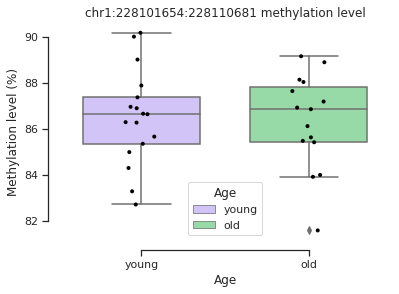

young average methylation: 18.508219170625
old average methylation: 18.324493595000003


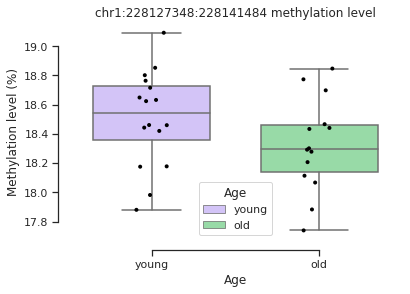

young average methylation: 84.58222448999997
old average methylation: 84.520171429


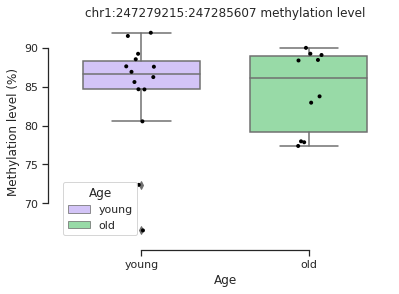

young average methylation: 0.208315644660625
old average methylation: 0.181129716974375


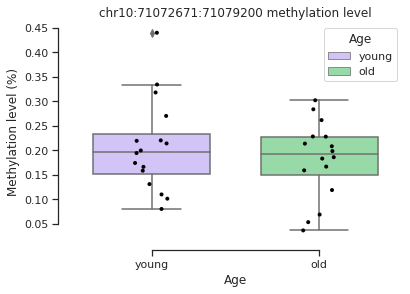

young average methylation: 75.86204615466666
old average methylation: 75.59218681357143


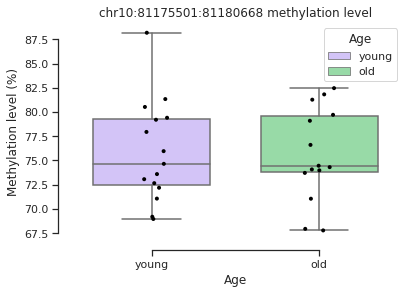

young average methylation: 92.193577778
old average methylation: 91.47652083125001


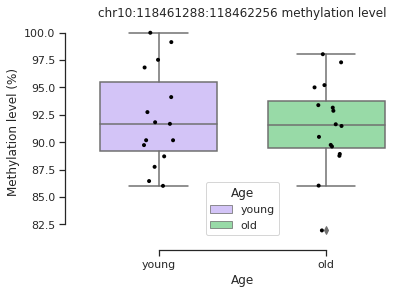

young average methylation: 55.52302380999999
old average methylation: 48.460848485727276


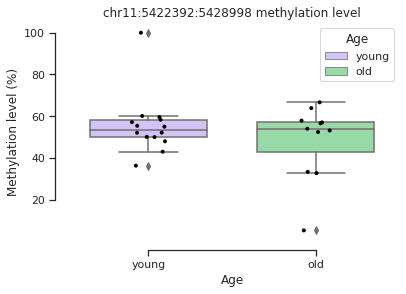

young average methylation: 1.5362830349411762
old average methylation: 1.4915958131111111


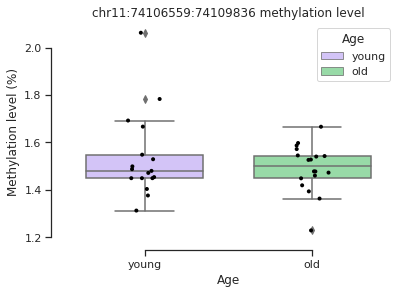

young average methylation: 94.10159259166666
old average methylation: 91.10933333294119


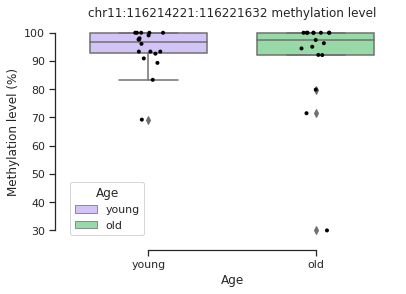

young average methylation: 88.88377884692308
old average methylation: 87.78475490235293


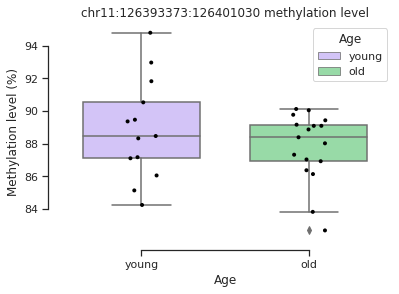

young average methylation: 77.45988333333332
old average methylation: 77.07689444444446


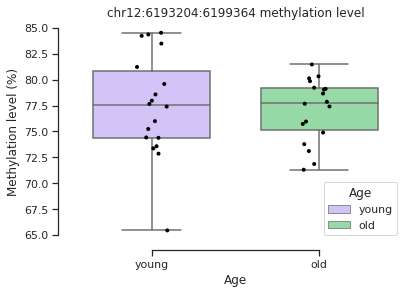

young average methylation: 89.61267647058824
old average methylation: 89.02478124875


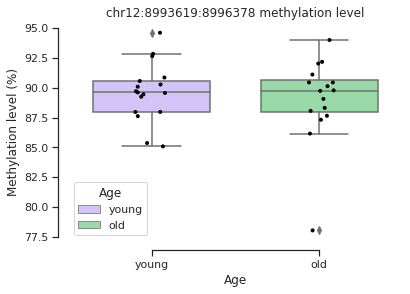

young average methylation: 96.42200000199999
old average methylation: 95.58855555533334


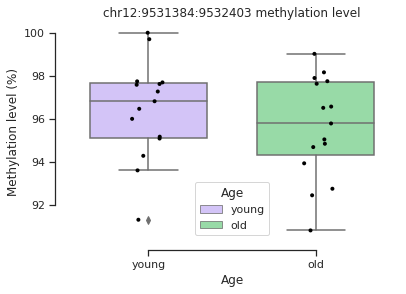

young average methylation: 95.1941176470588
old average methylation: 94.03822352941177


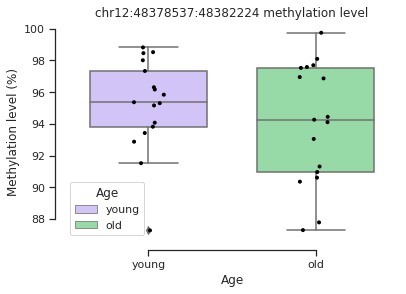

young average methylation: 6.229684873882354
old average methylation: 6.107811508


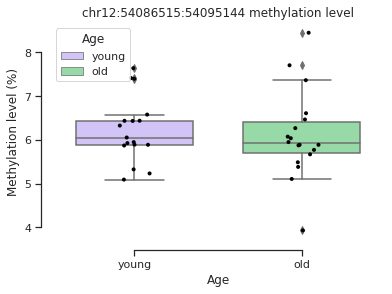

young average methylation: 63.603144444444446
old average methylation: 63.275233333333325


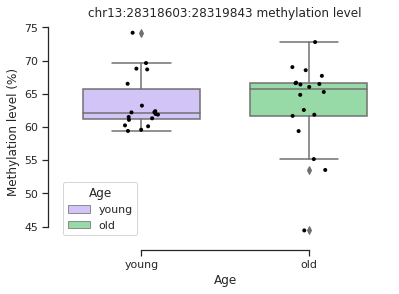

young average methylation: 27.39546153846154
old average methylation: 25.087781818181817


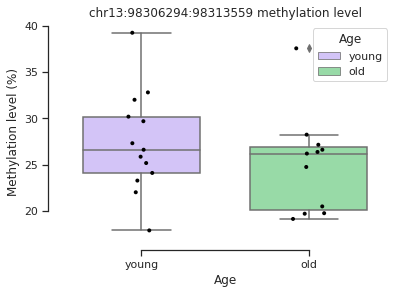

young average methylation: 78.74431770875
old average methylation: 77.43781770812501


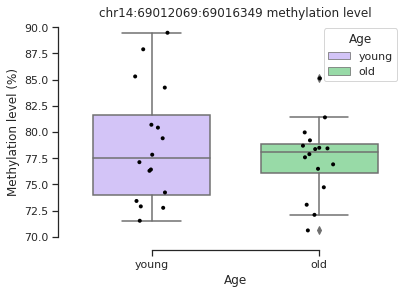

young average methylation: 67.49758441636365
old average methylation: 66.9078377975


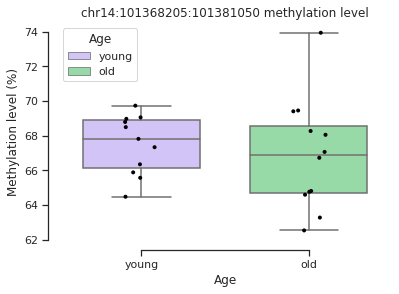

young average methylation: 87.475321368
old average methylation: 86.96368343076924


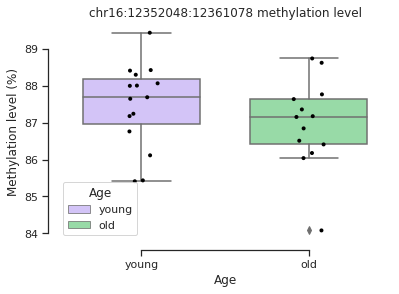

young average methylation: 74.31287181928573
old average methylation: 73.770610444375


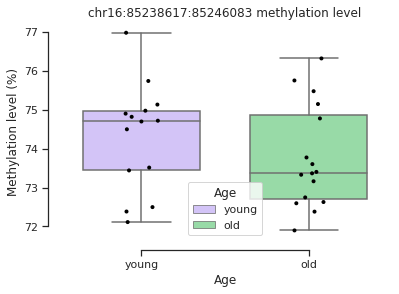

young average methylation: 81.96232380999999
old average methylation: 80.823809524


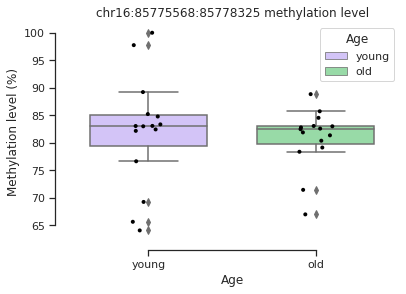

young average methylation: 93.09146666666668
old average methylation: 91.05621666666666


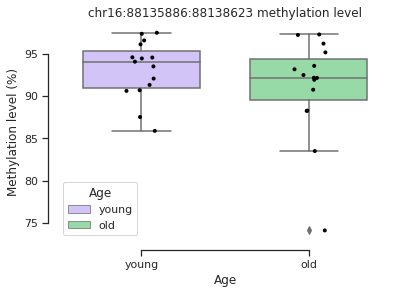

young average methylation: 87.93140000133333
old average methylation: 87.921694854375


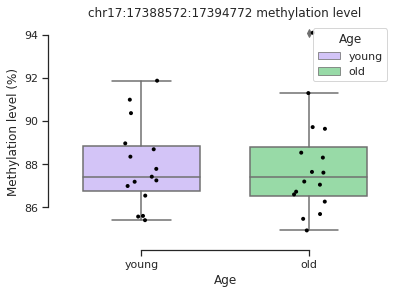

young average methylation: 60.78097777866666
old average methylation: 59.825644444666665


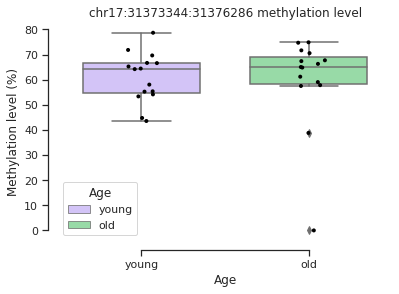

young average methylation: 84.47118452428572
old average methylation: 83.53536805583333


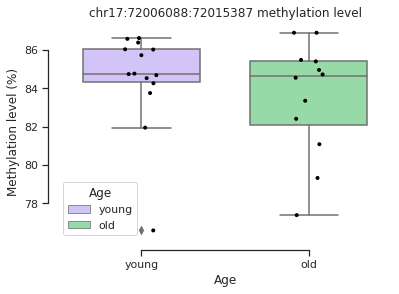

young average methylation: 44.92706413857144
old average methylation: 44.841010205


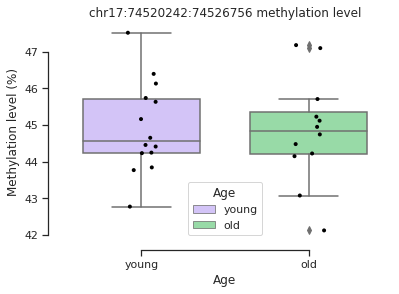

young average methylation: 93.92927678571428
old average methylation: 93.58749999999999


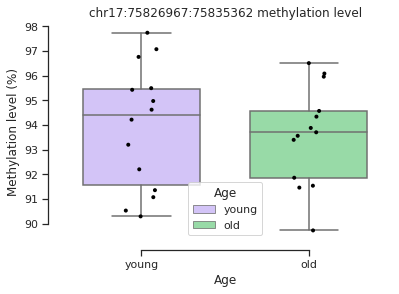

young average methylation: 90.73717647117648
old average methylation: 90.648133332


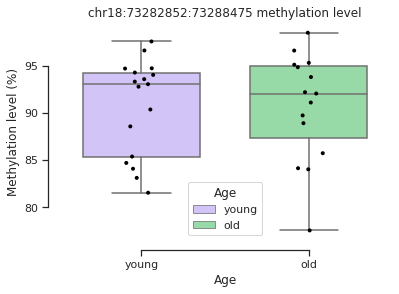

young average methylation: 87.31756666666668
old average methylation: 86.44225000000002


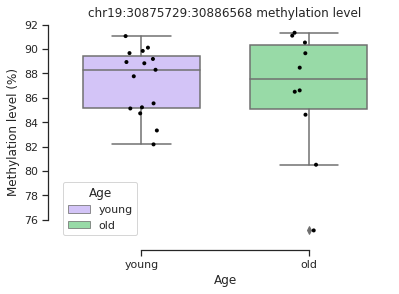

young average methylation: 80.98193749937501
old average methylation: 80.84842115647061


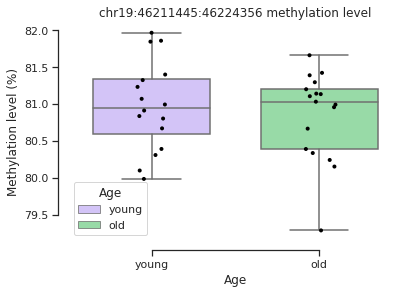

young average methylation: 96.41973176470589
old average methylation: 96.239968


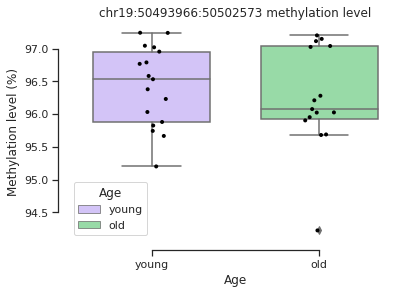

young average methylation: 93.78785294117648
old average methylation: 93.35085294117647


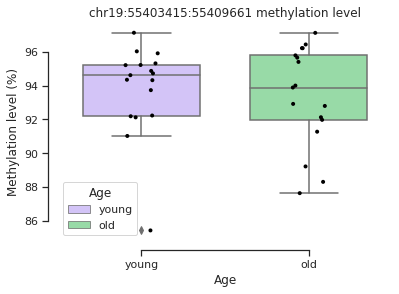

young average methylation: 94.39768484866667
old average methylation: 93.418357574


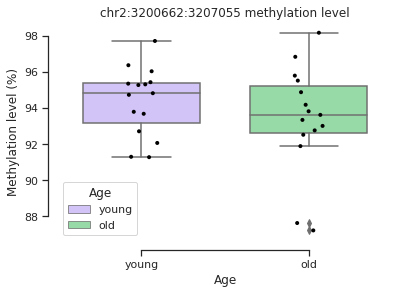

young average methylation: 95.39908333333334
old average methylation: 94.76014743615386


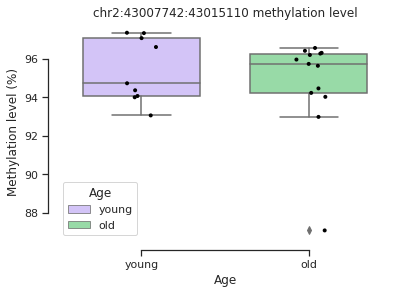

young average methylation: 1.1834785373411763
old average methylation: 0.82689020270625


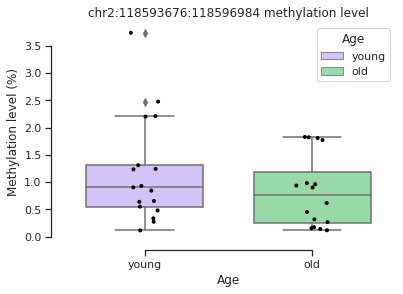

young average methylation: 94.92454061647058
old average methylation: 93.5876598635714


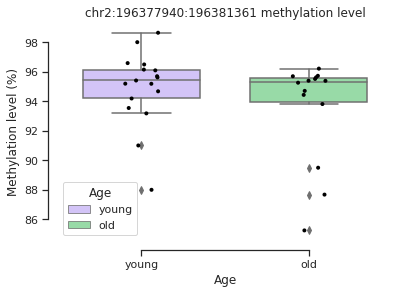

young average methylation: 13.84799253117647
old average methylation: 13.823554421428572


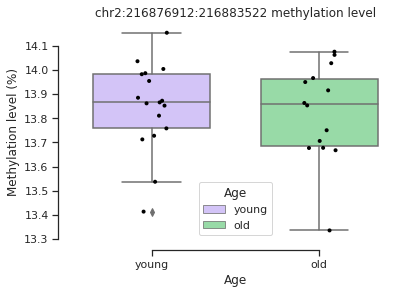

young average methylation: 95.425453125
old average methylation: 94.34690625000002


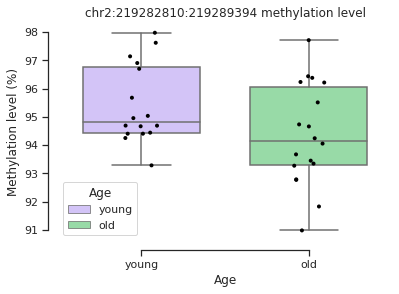

young average methylation: 9.80694983864706
old average methylation: 9.760784765833334


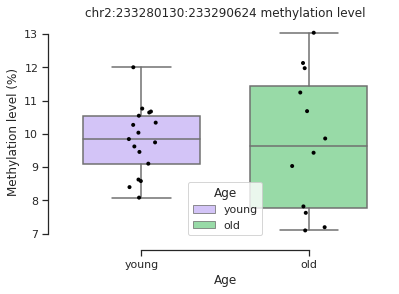

young average methylation: 88.128055555
old average methylation: 87.22372222277778


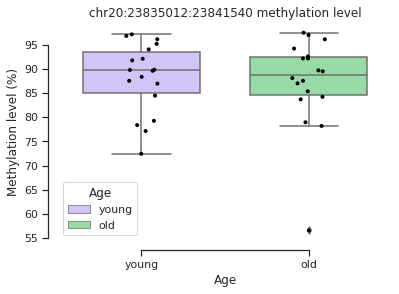

young average methylation: 5.8431323529411765
old average methylation: 5.755877604125


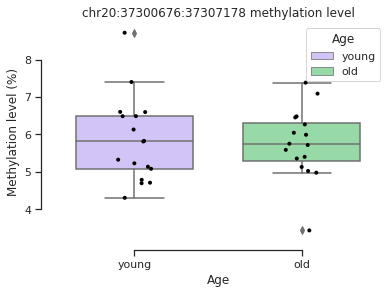

young average methylation: 94.71351260529411
old average methylation: 93.80944537764707


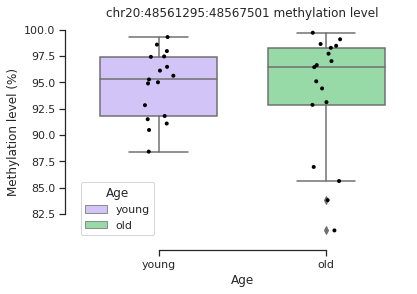

young average methylation: 90.63379555466666
old average methylation: 90.15374761928571


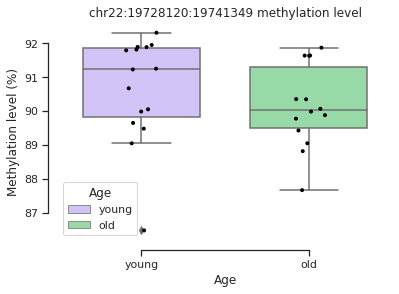

young average methylation: 6.790018181909091
old average methylation: 6.733645989181818


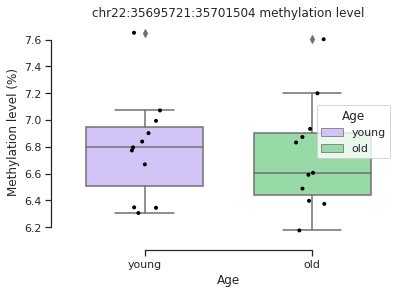

young average methylation: 93.12866911750001
old average methylation: 92.96522745133332


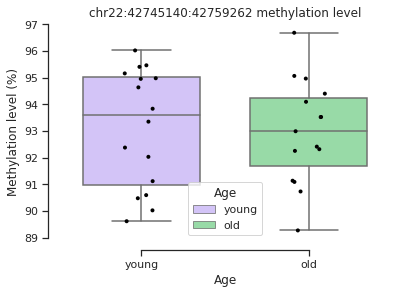

young average methylation: 81.31890760937499
old average methylation: 80.84221483352941


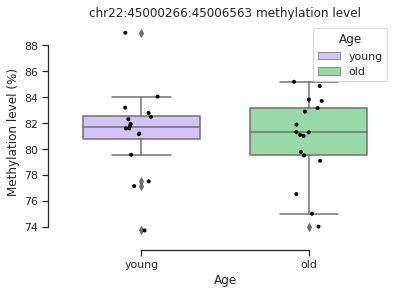

young average methylation: 2.6045598739411764
old average methylation: 2.1170079365555554


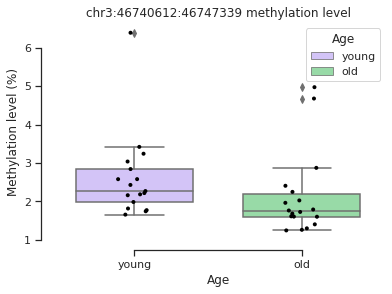

young average methylation: 91.63438152874998
old average methylation: 91.60755662764707


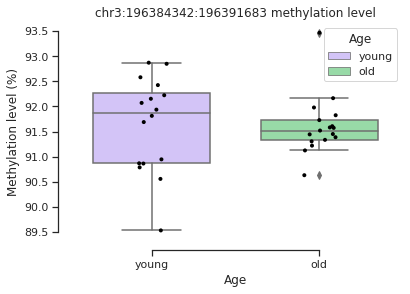

young average methylation: 95.11416161666666
old average methylation: 94.64068181812499


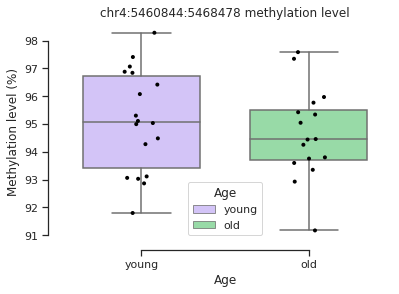

young average methylation: 7.727564705647059
old average methylation: 7.115151260529412


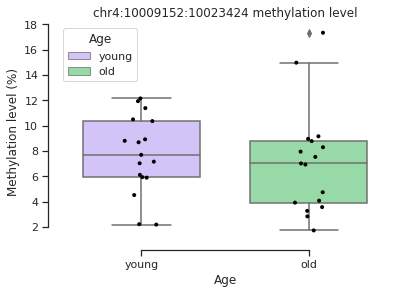

young average methylation: 92.04146875000002
old average methylation: 91.41721428571428


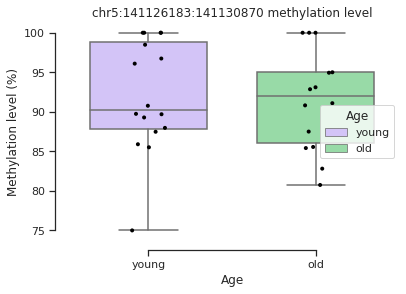

young average methylation: 13.220178104117648
old average methylation: 13.168970588235295


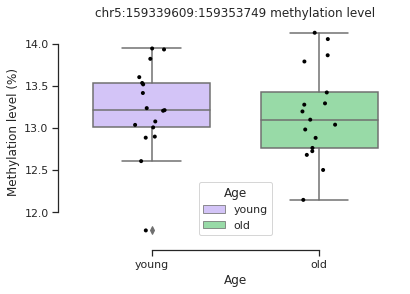

young average methylation: 95.093656249375
old average methylation: 93.934177084375


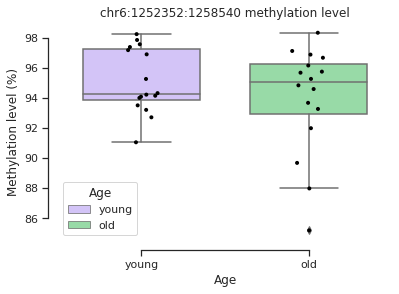

young average methylation: 90.325229166875
old average methylation: 89.01026666666668


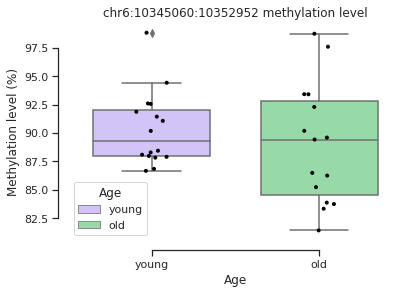

young average methylation: 87.34396256588235
old average methylation: 86.0763181825


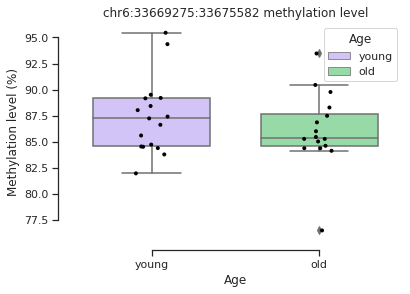

young average methylation: 1.3168078398125
old average methylation: 1.2715236843000002


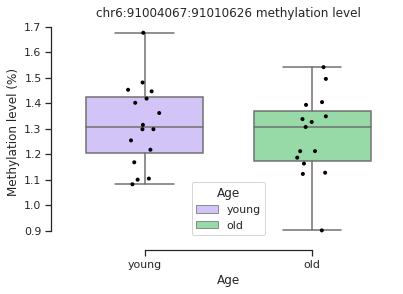

young average methylation: 80.06888235235294
old average methylation: 80.05289444466666


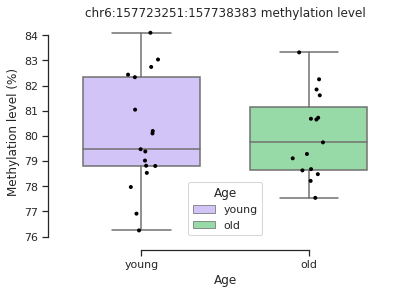

young average methylation: 94.57037255055555
old average methylation: 94.393886029375


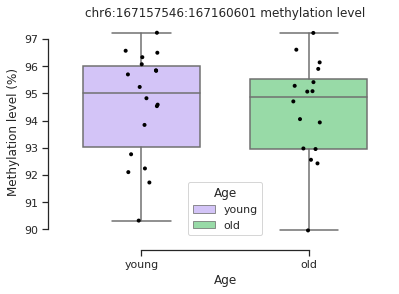

young average methylation: 96.89335294117645
old average methylation: 92.46100000000001


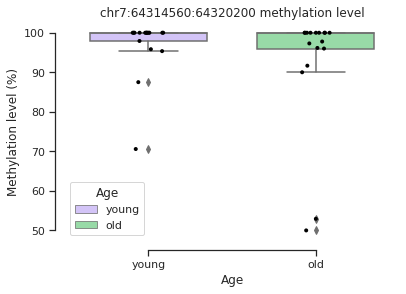

young average methylation: 91.43259722222224
old average methylation: 91.07955555555556


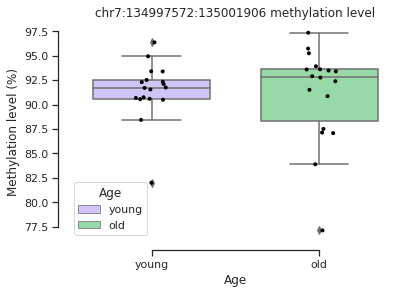

young average methylation: 88.68011830357143
old average methylation: 88.64708088235295


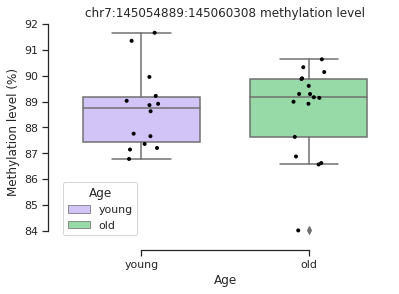

young average methylation: 84.52553846153847
old average methylation: 81.99884615384615


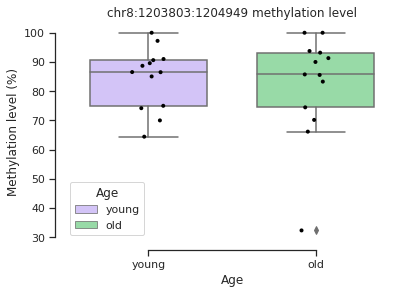

young average methylation: 32.91844999999999
old average methylation: 31.724878125000004


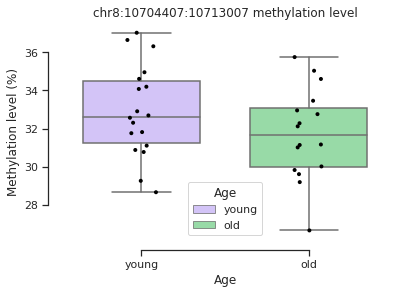

young average methylation: 95.91886111133334
old average methylation: 95.62588095285714


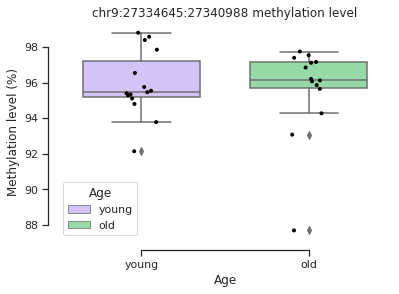

young average methylation: 87.487025
old average methylation: 87.02226527777776


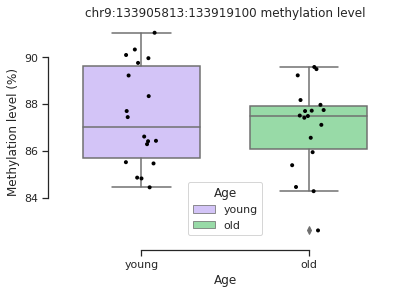

young average methylation: 0.7975482352941177
old average methylation: 0.7629172222222222


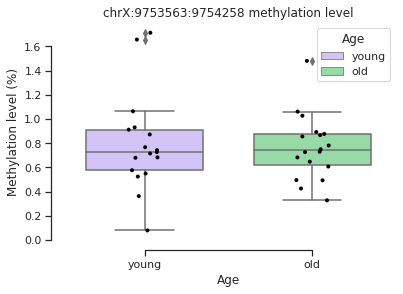

In [42]:
for interval in young_down_methylated["interval"]:
    a = young_down_methylated.query('interval == @interval')
    b = old_down_methylated.query('interval == @interval')
    c = pd.concat([a.assign(Age='young'), b.assign(Age='old')])
    c = c.drop([0, 1, 2], axis=1)
    d = pd.melt(c, id_vars=['Age', 'interval'])
    
    print('young average methylation: ' + str(d.query('Age == "young"')["value"].mean()))
    print('old average methylation: ' + str(d.query('Age == "old"')["value"].mean()))
    
    sns.set(rc={'figure.figsize':(6, 4)}, style='whitegrid')
    sns.set_theme(style="ticks", palette="pastel")    
    
    sns.boxplot(x="Age", hue="Age", y="value", data=d, palette=["m", "g"], width=0.7, dodge=False).set_title("{} methylation level".format(interval))
    sns.stripplot(x="Age", y="value", data=d, color='black', s=4)
    sns.despine(offset=10, trim=True)
    plt.ylabel("Methylation level (%)")
    plt.show()

#### Save up- and downmethylated regions in bed files:

In [547]:
# save diff methylated

diff_meth_by_interval_save = young[young["interval"].isin(diff_meth_by_interval["interval"])]  
diff_meth_by_interval_save = diff_meth_by_interval_save.iloc[:, 1:4]
diff_meth_by_interval_save.to_csv("diff_methylated_intervals.bed", index=False, header=None, sep='\t')

In [380]:
# save upmethylated

result_up_methylated = young[young["interval"].isin(up_methylated["interval"])]  
result_up_methylated = result_up_methylated.iloc[:, 1:4]
result_up_methylated.to_csv("up_methylated_intervals.bed", index=False, header=None, sep='\t')

In [448]:
# save downmethylated

result_down_methylated = young[young["interval"].isin(down_methylated["interval"])]  
result_down_methylated = result_down_methylated.iloc[:, 1:4]
result_down_methylated.to_csv("down_methylated_intervals.bed", index=False, header=None, sep='\t')

### 8. Scatterplot visualization

#### WGBS

1. Download methylation level data

In [52]:
!mkdir wgbs_data && cd wgbs_data && mkdir methylation_signal && mkdir coverage && mkdir filtered_meth

In [ ]:
%%bash

cd ./wgbs_data/methylation_signal/ && wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/S000RD/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/S000RD54.CPG_methylation_calls.bs_call.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/C005PS/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C005PS51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C0010K/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C0010KA2bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C000S5/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C001UY/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C004SQ/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw'

2. Download coverage data

In [ ]:
%%bash

cd ./wgbs_data/coverage/ && wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/S000RD/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/S000RD54.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/C005PS/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C005PS51.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C0010K/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C0010KA2bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C000S5/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C000S5A1bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C001UY/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C001UYA3bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw' \ 
&& wget 'http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C004SQ/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C004SQ51.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw'

3. Converting signal and coverage to bedGraph format

In [65]:
signal = glob.glob('./wgbs_data/methylation_signal/*.bw')

In [ ]:
for file in signal:
    file_name = file.split('.bw')[-2]
    outfile_name = file_name + '.bedGraph'
    !bigWigToBedGraph $file $outfile_name

In [89]:
coverage = glob.glob('./wgbs_data/coverage/*.bw')

In [ ]:
for file in coverage:
    file_name = file.split('.bw')[-2]
    outfile_name = file_name + '.bedGraph'
    !bigWigToBedGraph $file $outfile_name

4. Filtering methylation data by coverage (leave signal with almost 4 reads)

In [68]:
signal_bedgraph = sorted(glob.glob('./wgbs_data/methylation_signal/*.bedGraph'))

In [58]:
coverage_bedgraph = sorted(glob.glob('./wgbs_data/coverage/*.bedGraph'))

In [59]:
for i in range(len(signal_bedgraph)):
    outfile = './wgbs_data/methylation_signal/' + 'meth_with_cov_' + str(signal_bedgraph[i].split("/")[-1])
    tempfile = './wgbs_data/methylation_signal/temp' + str(i)
    filtered = './wgbs_data/filtered_meth/' + str(signal_bedgraph[i].split("/")[-1])
    
    !paste -d '\t' {signal_bedgraph[i]} {coverage_bedgraph[i]} | cut -f 1,2,3,4,8 > $outfile
    !awk '($5 >= 4)' $outfile > $tempfile
    !awk '{{print $$1"\t"$$2"\t"$$3"\t"$$4}}' $tempfile > $filtered
    !rm $tempfile

5. Mapping filtered methylation data on differentially methylated intervals

In [62]:
!mkdir ./wgbs_data/mapped

In [70]:
filtered_meth_data = glob.glob('./wgbs_data/filtered_meth/*.bedGraph')

In [63]:
diff_methylated = './diff_methylated_intervals.bed'

for file in filtered_meth_data:
    outfile_name = './wgbs_data/mapped/' + str(file.split('/')[-1])
    !bedtools map -a $diff_methylated -b $file -c 4 -o mean > $outfile_name

Reading WGBS methylation data:

In [3]:
old_one = pd.read_table("./wgbs_data/mapped/C0010KA2bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bedGraph", sep="\t", header=None)
old_two = pd.read_table("./wgbs_data/mapped/C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bedGraph", sep="\t", header=None)
old_three = pd.read_table("./wgbs_data/mapped/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bedGraph", sep="\t", header=None)
old_four = pd.read_table("./wgbs_data/mapped/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bedGraph", sep="\t", header=None)

old_two = pd.DataFrame(old_two.iloc[:,3])
old_three = pd.DataFrame(old_three.iloc[:,3])
old_four = pd.DataFrame(old_four.iloc[:,3])

all_old = pd.concat([old_one, old_two, old_three, old_four], axis=1)
all_old.insert(0, 'interval', all_old[all_old.columns[:3]].apply(lambda x: ':'.join(x.astype(str)), axis=1))

young_one = pd.read_table("./wgbs_data/mapped/S000RD54.CPG_methylation_calls.bs_call.GRCh38.20160531.bedGraph", sep="\t", header=None)
young_two = pd.read_table("./wgbs_data/mapped/C005PS51.CPG_methylation_calls.bs_call.GRCh38.20160531.bedGraph", sep="\t", header=None)
young_two = pd.DataFrame(young_two.iloc[:,3])

all_young = pd.concat([young_one, young_two], axis=1)
all_young.insert(0, 'interval', all_young[all_young.columns[:3]].apply(lambda x: ':'.join(x.astype(str)), axis=1))

In [4]:
# renaming old donors and calculating average methylation

wgbs_old = all_old.iloc[:, [0, 4, 5, 6, 7]]
wgbs_old.columns = ['interval', 'donor1', 'donor2', 'donor3', 'donor4']
wgbs_old["mean_meth_old"] = wgbs_old.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').mean(axis=1)

<ipython-input-4-e20361c257ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wgbs_old["mean_meth_old"] = wgbs_old.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').mean(axis=1)


In [5]:
wgbs_old.head()

interval        donor1        donor2        donor3  \
0    chr1:3000150:3007572  0.8902578947        0.8814  0.8937457627   
1    chr1:9317697:9324383  0.7739748744  0.7895050505   0.765238806   
2  chr1:12048280:12054670  0.8241914894   0.824979798  0.8259690722   
3  chr1:29205521:29216481  0.9338881988  0.9222064516  0.9333703704   
4  chr1:33768785:33782835  0.8300598291  0.8211403509  0.8440847458   

         donor4  mean_meth_old  
0  0.8983225806       0.890932  
1  0.9096616541       0.809595  
2  0.9374810127       0.853155  
3  0.9456304348       0.933774  
4  0.8870588235       0.845586

In [6]:
# renaming young donors and calculating average methylation

wgbs_young = all_young.iloc[:,[0, 4, 5]]
wgbs_young.columns = ['interval', 'donor1', 'donor2']
wgbs_young["mean_meth_young"] = wgbs_young.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').mean(axis=1)

<ipython-input-6-f9fabcd64d0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wgbs_young["mean_meth_young"] = wgbs_young.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').mean(axis=1)


In [7]:
wgbs_young.head()

interval        donor1        donor2  mean_meth_young
0    chr1:3000150:3007572  0.8972967033  0.8815989305         0.889448
1    chr1:9317697:9324383   0.771798995  0.7516386139         0.761719
2  chr1:12048280:12054670  0.8199270833  0.8169479167         0.818437
3  chr1:29205521:29216481  0.9304691358  0.9292345679         0.929852
4  chr1:33768785:33782835   0.850720339  0.8441238938         0.847422

In [26]:
dataset2 = diff_meth_by_interval.copy()

In [27]:
# calculating methylation difference between old and young donors

dataset2["diff"] = dataset2["old"] - dataset2["young"]

In [45]:
dataset2.head()

Age                   interval        old      young      diff
0    chr10:118461288:118462256  91.476521  92.193578 -0.717057
1    chr10:125984039:125985395  64.130176  62.150000  1.980176
2    chr10:127832970:127839261  96.675214  91.155000  5.520214
3    chr10:134515226:134526450  93.772975  93.526651  0.246324
4      chr10:25459698:25466297   4.523981   3.111883  1.412097

In [28]:
# merging RRBS and WGBS methylation data

result_ds = dataset2.merge(wgbs_old.iloc[:, [0,5]], on="interval").merge(wgbs_young.iloc[:,[0,3]], on='interval')
result_ds.head()

interval        old      young      diff  mean_meth_old  \
0  chr10:118461288:118462256  91.476521  92.193578 -0.717057       0.868853   
1  chr10:125984039:125985395  64.130176  62.150000  1.980176       0.790763   
2  chr10:127832970:127839261  96.675214  91.155000  5.520214       0.921294   
3  chr10:134515226:134526450  93.772975  93.526651  0.246324            NaN   
4    chr10:25459698:25466297   4.523981   3.111883  1.412097       0.893366   

   mean_meth_young  
0         0.861438  
1         0.822321  
2         0.907246  
3              NaN  
4         0.912647

In [29]:
# WGBS methylation values to percent

result_ds["mean_meth_old"] = result_ds["mean_meth_old"] * 100
result_ds["mean_meth_young"] = result_ds["mean_meth_young"] * 100

In [994]:
result_ds.head()

interval        old      young      diff  mean_meth_old  \
0  chr10:118461288:118462256  91.476521  92.193578 -0.717057      86.885268   
1  chr10:125984039:125985395  64.130176  62.150000  1.980176      79.076310   
2  chr10:127832970:127839261  96.675214  91.155000  5.520214      92.129356   
3  chr10:134515226:134526450  93.772975  93.526651  0.246324            NaN   
4    chr10:25459698:25466297   4.523981   3.111883  1.412097      89.336552   

   mean_meth_young  
0        86.143750  
1        82.232143  
2        90.724615  
3              NaN  
4        91.264706

In [31]:
# red if methylation in region increased, green if decreased, yellow if not changed

custom_palette = {}
for q in set(result_ds["diff"]):
    if q < 0:
        custom_palette[q] = 'r'
    elif q == 0:
        custom_palette[q] = 'y'
    else:
        custom_palette[q] = 'g'

#### Scatterplot on RRBS data, colored by RRBS data

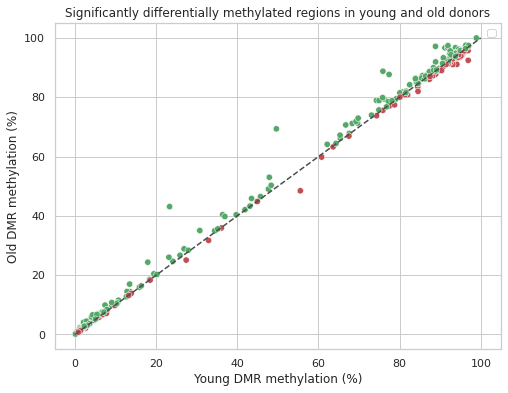

In [32]:
sns.set(rc={'figure.figsize':(8, 6)}, style='whitegrid')
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

ax = sns.scatterplot(x=result_ds["young"], y=result_ds["old"], hue=result_ds["diff"], palette=custom_palette, s=40)

ident = [0.0, 100.0]
plt.plot(ident,ident, ls="--", c=".3")

plt.xlabel("Young DMR methylation (%)")
plt.ylabel("Old DMR methylation (%)")
plt.title("Significantly differentially methylated regions in young and old donors")

ax.legend([])

Text(0.5, 1.0, 'Significantly differentially methylated regions in young and old donors')

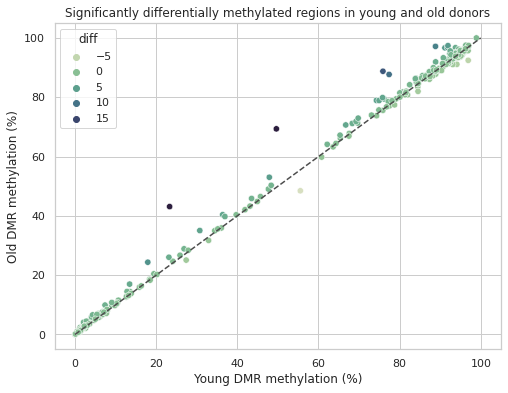

In [33]:
sns.set(rc={'figure.figsize':(8, 6)}, style='whitegrid')
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

ax = sns.scatterplot(x=result_ds["young"], y=result_ds["old"], hue=result_ds["diff"], palette=cmap, s=40)

ident = [0.0, 100.0]
plt.plot(ident,ident, ls="--", c=".3")

plt.xlabel("Young DMR methylation (%)")
plt.ylabel("Old DMR methylation (%)")
plt.title("Significantly differentially methylated regions in young and old donors")

# ax.legend([])

#### Scatterplot on WGBS data, colored by RRBS data

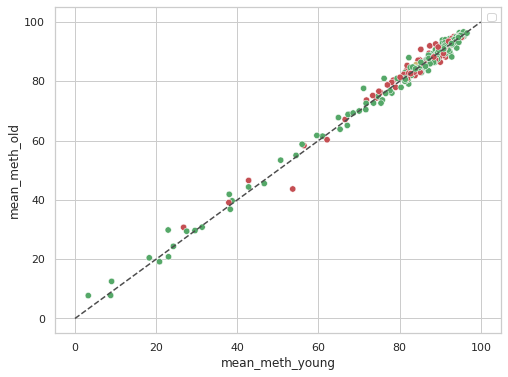

In [35]:
sns.set(rc={'figure.figsize':(8, 6)}, style='whitegrid')
# cmap = sns.diverging_palette(145, 300, s=100, as_cmap=True)

ax = sns.scatterplot(x=result_ds["mean_meth_young"], y=result_ds["mean_meth_old"], hue=result_ds["diff"], palette=custom_palette, s=40)

ident = [0.0, 100.0]
plt.plot(ident,ident, ls="--", c=".3")

ax.legend([])

#### Scatterplot on WGBS data, colored by RRBS data
Only regions with > 2% diff

In [30]:
filtered_result_ds = result_ds.query('(diff < -2) or (diff > 2)')

In [1077]:
filtered_result_ds.head()

interval        old      young      diff  mean_meth_old  \
2   chr10:127832970:127839261  96.675214  91.155000  5.520214      92.129356   
11  chr11:116214221:116221632  91.109333  94.101593 -2.992259      80.384790   
13  chr11:124787666:124795856   4.131175   2.123460  2.007715      93.736563   
15      chr11:5422392:5428998  48.460848  55.523024 -7.062175      89.449472   
24  chr12:121393481:121397575  79.440467  76.158789  3.281678      93.985321   

    mean_meth_young  
2         90.724615  
11        78.464286  
13        93.844681  
15        87.253420  
24        94.470706

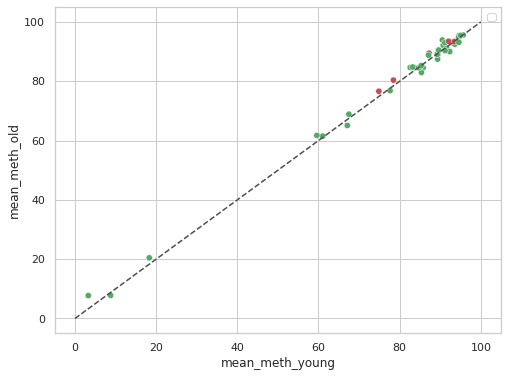

In [37]:
sns.set(rc={'figure.figsize':(8, 6)}, style='whitegrid')
# cmap = sns.diverging_palette(145, 300, s=100, as_cmap=True)

ax = sns.scatterplot(x=filtered_result_ds["mean_meth_young"], y=filtered_result_ds["mean_meth_old"], hue=filtered_result_ds["diff"], palette=custom_palette, s=40)

ident = [0.0, 100.0]
plt.plot(ident,ident, ls="--", c=".3")

ax.legend([])